In [2]:
%load_ext autoreload
%autoreload 2

import os
# Run everything on CPU, if GPU is available comment out
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import sys
sys.path.append("src/")
import src.preprocessing.data_loading as data_loading
import src.preprocessing.SL_Xstreme as SL_Xstreme
import src.preprocessing.SL_PCA as SL_PCA
import models.experiment as experiment
import models.rnn as rnn
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.spatial.distance import cdist
from Bio import SeqIO
from collections import Counter
from xml.etree import ElementTree as ET
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
from tensorflow import keras
from functools import partial
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from analysis.hit_rate_analysis import (
    plot_ratio_by_ranking,
    seq_contains_mdm2_motif,
    seq_contains_12ca5_motif,
    benchmark_cross_validated_hit_rate,
)
from analysis.scatter_plots import (
    plot_fancy_hexbin_relations
)
from models.rnn import multi_channel_mse

Generating ER datafiles!


In [3]:
protein_of_interest = "MDM2"
other_protein = "12ca5"

def proxy_ranking_lambda(x):
    # Proxy metric is defined as FC (y_raw[:, 1]) + ER (y_raw[:, 2])
    return 1*x[1] + 1*x[2] + 0*x[0]

top_k_size = 500 if protein_of_interest == "MDM2" else 1000
motif_dectection_func = (
    seq_contains_mdm2_motif
    if protein_of_interest == "MDM2"
    else seq_contains_12ca5_motif
)
model_save_name = (
    "trained_models/final_models/mdm2_model.h5"
    if protein_of_interest == "MDM2"
    else "trained_models/final_models/12ca5_model.h5"
)


X, y_raw, peptides, FEATURE_LIST = data_loading.build_joint_dataset(
    er_datafile=f"{protein_of_interest}_merged_ER.csv",
    volcano_datafile="12ca5-MDM2-R3.csv",
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
)
print(len(FEATURE_LIST))
print(FEATURE_LIST)
print(y_raw[0])

print(X.shape)


jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0                        

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


## Baseline Experimental Rankings

(-11.26699745539576, 12.802835987110129, -0.8329379238887278, 27.369964117469774)


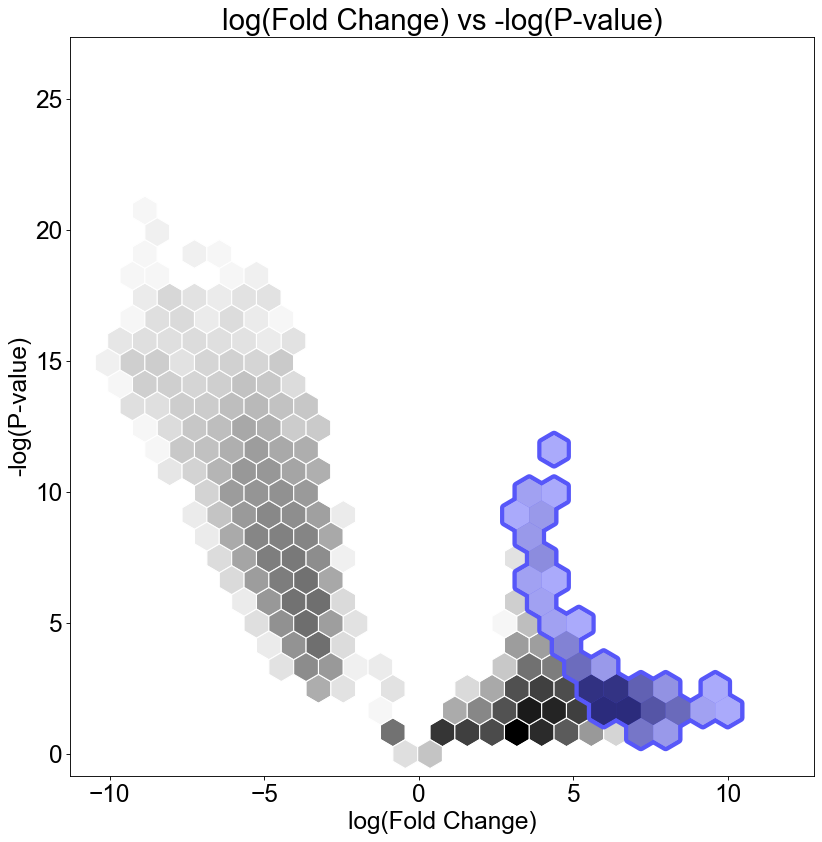

Try  2.1972245773362196
2.1972245773362196
(-11.26699745539576, 12.802835987110129, -0.8329379238887278, 27.369964117469774)


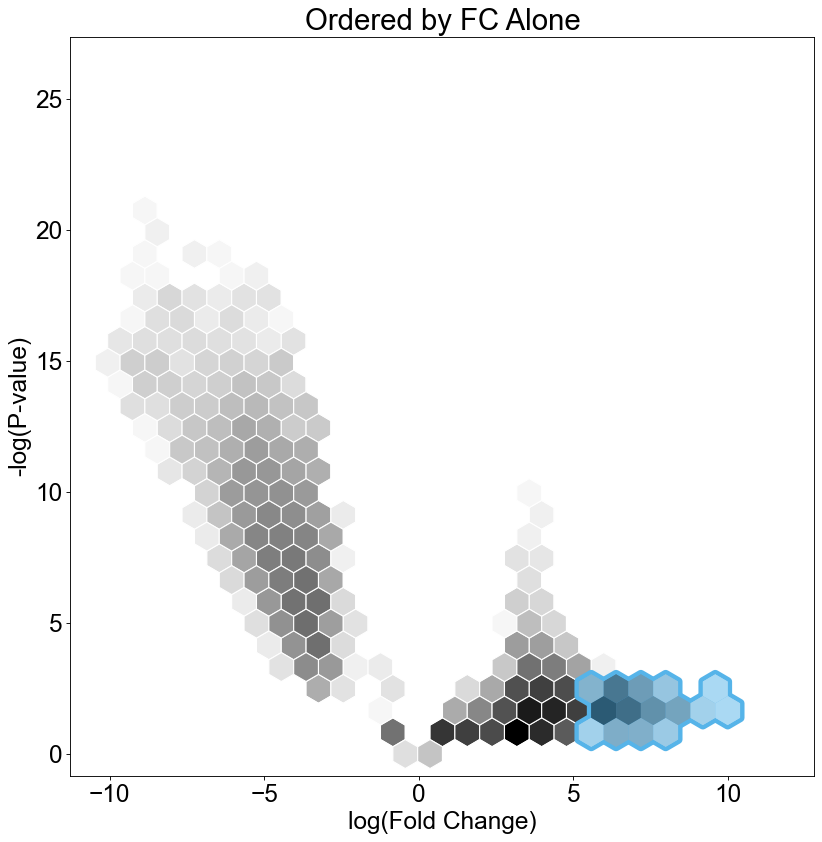

(-12.424972942105276, 18.0343835663439, -11.26699745539576, 12.802835987110129)


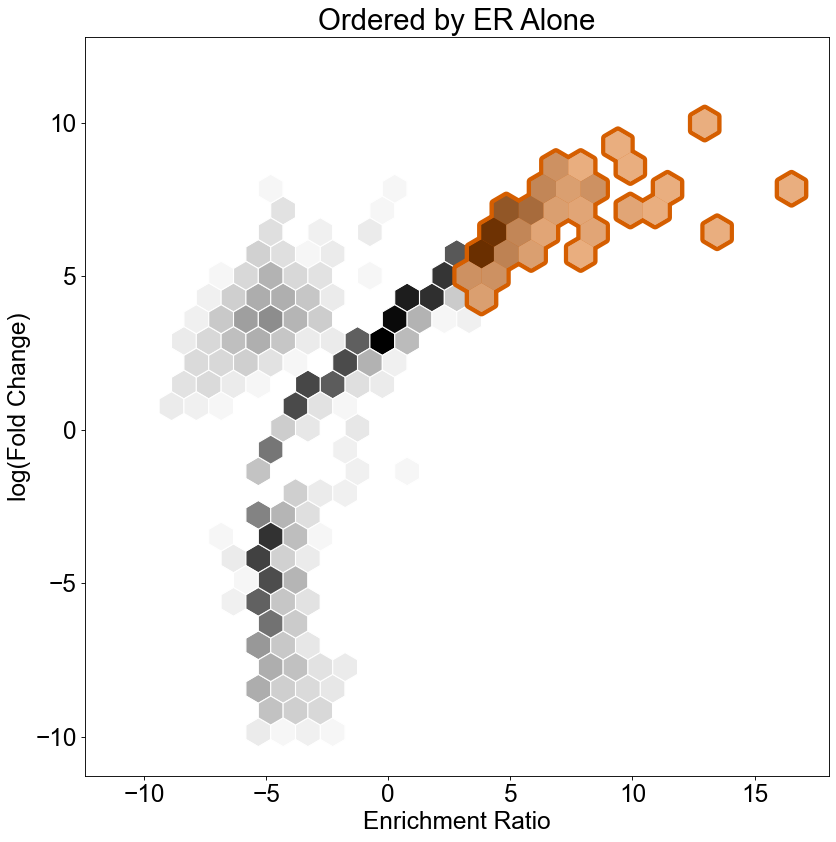

(-12.424972942105276, 18.0343835663439, -11.26699745539576, 12.802835987110129)


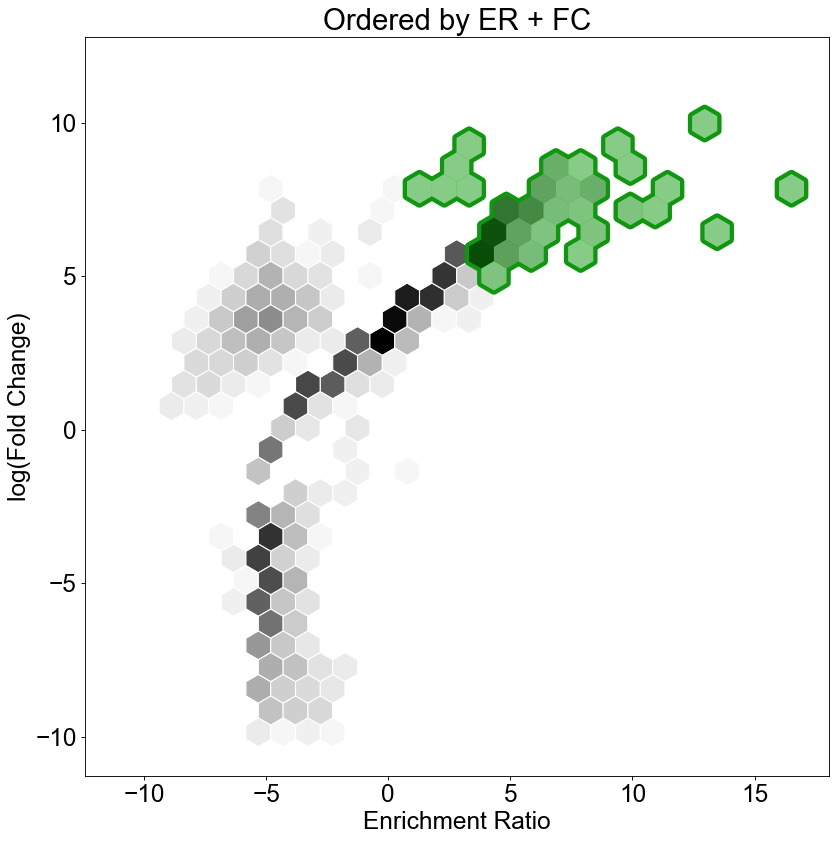

In [4]:
volcano_ordering = (
    np.array([(val[0] + 6) * val[1] if val[1] > 0 else 0 for val in y_raw])
    if protein_of_interest == "MDM2"
    else np.array([val[0] * val[1] for val in y_raw])
)

plot_fancy_hexbin_relations(
    1,
    0,
    datapoints=y_raw,
    ordering=volcano_ordering,
    all_positives=None,
    line_color='#5757F9',
    top_k=top_k_size,
)

fc_alone_mdm2_ordering = [y[1] for y in y_raw]

print("Try ",y_raw[0][1])
print(fc_alone_mdm2_ordering[0])
plot_fancy_hexbin_relations(
    1,
    0,
    datapoints=y_raw,
    ordering=fc_alone_mdm2_ordering,
    all_positives=None,
    line_color='#56B4E9',
    title='Ordered by FC Alone',
    top_k=top_k_size,
)

er_mdm2_ordering = [y[2] for y in y_raw]


plot_fancy_hexbin_relations(
    2,
    1,
    datapoints=y_raw,
    ordering=er_mdm2_ordering,
    all_positives=None,
    line_color='#D55E00',
    title='Ordered by ER Alone',
    top_k=top_k_size,
)

er_fc_joint_mdm2_ordering = [1*y[2] + y[1] + 0*y[0] for y in y_raw]

plot_fancy_hexbin_relations(
    2,
    1,
    datapoints=y_raw,
    ordering=er_fc_joint_mdm2_ordering,
    all_positives=None,
    line_color='#0F980F',
    title='Ordered by ER + FC',
    top_k=top_k_size,
)


AFCDWFWCS
drop C
max is  75.0
AFCDWFWCS
drop C
max is  67.0
AFCDWFWCS
drop C
max is  95.0


/Users/stephen/Desktop/PythonPhastPep/2_29_24/RatmirData/ml_phage_display-main/src/analysis/heatmap_analysis.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_aa = pd.Series(index=list('ARNDCQEGHILKMFPSTWYV'))
/Users/stephen/Desktop/PythonPhastPep/2_29_24/RatmirData/ml_phage_display-main/src/analysis/heatmap_analysis.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_aa = pd.Series(index=list('ARNDCQEGHILKMFPSTWYV'))
/Users/stephen/Desktop/PythonPhastPep/2_29_24/RatmirData/ml_phage_display-main/src/analysis/heatmap_analysis.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_aa = pd.Series(index=list('ARNDCQEGHILKMFPSTWYV')

AFCDWFWCS
drop C
max is  89.0


/Users/stephen/Desktop/PythonPhastPep/2_29_24/RatmirData/ml_phage_display-main/src/analysis/heatmap_analysis.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_aa = pd.Series(index=list('ARNDCQEGHILKMFPSTWYV'))


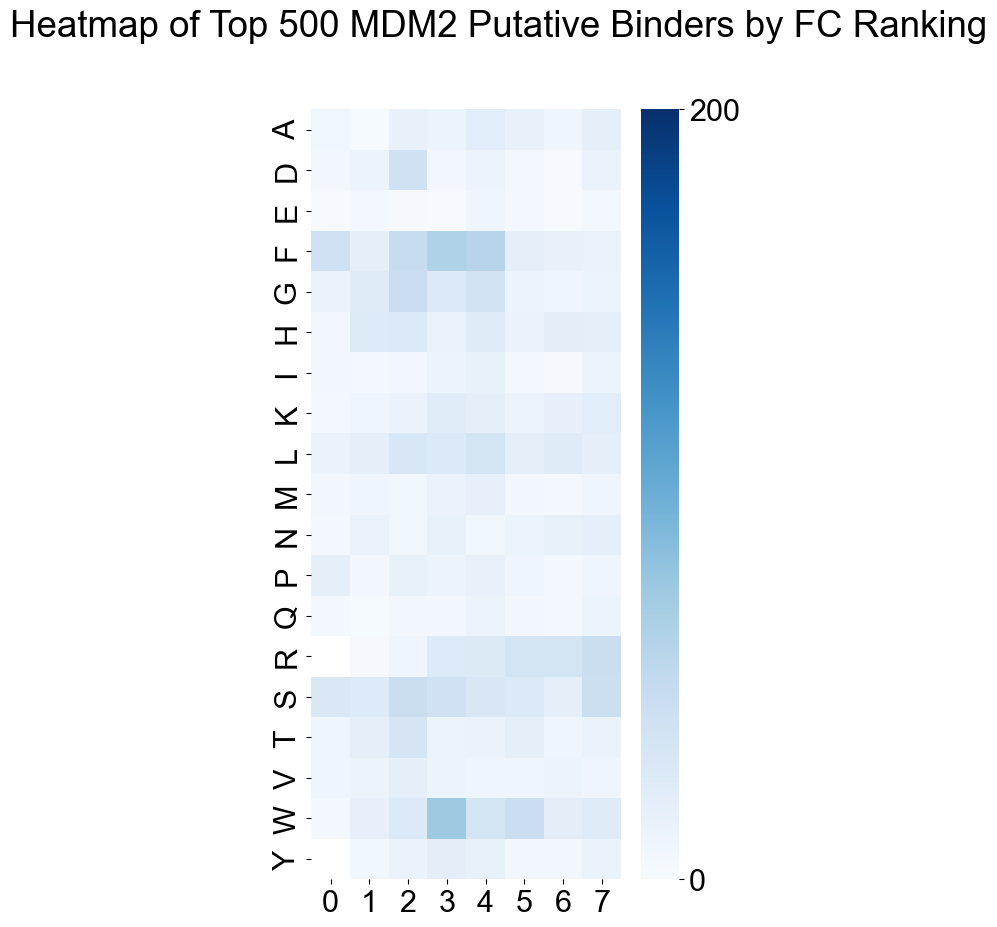

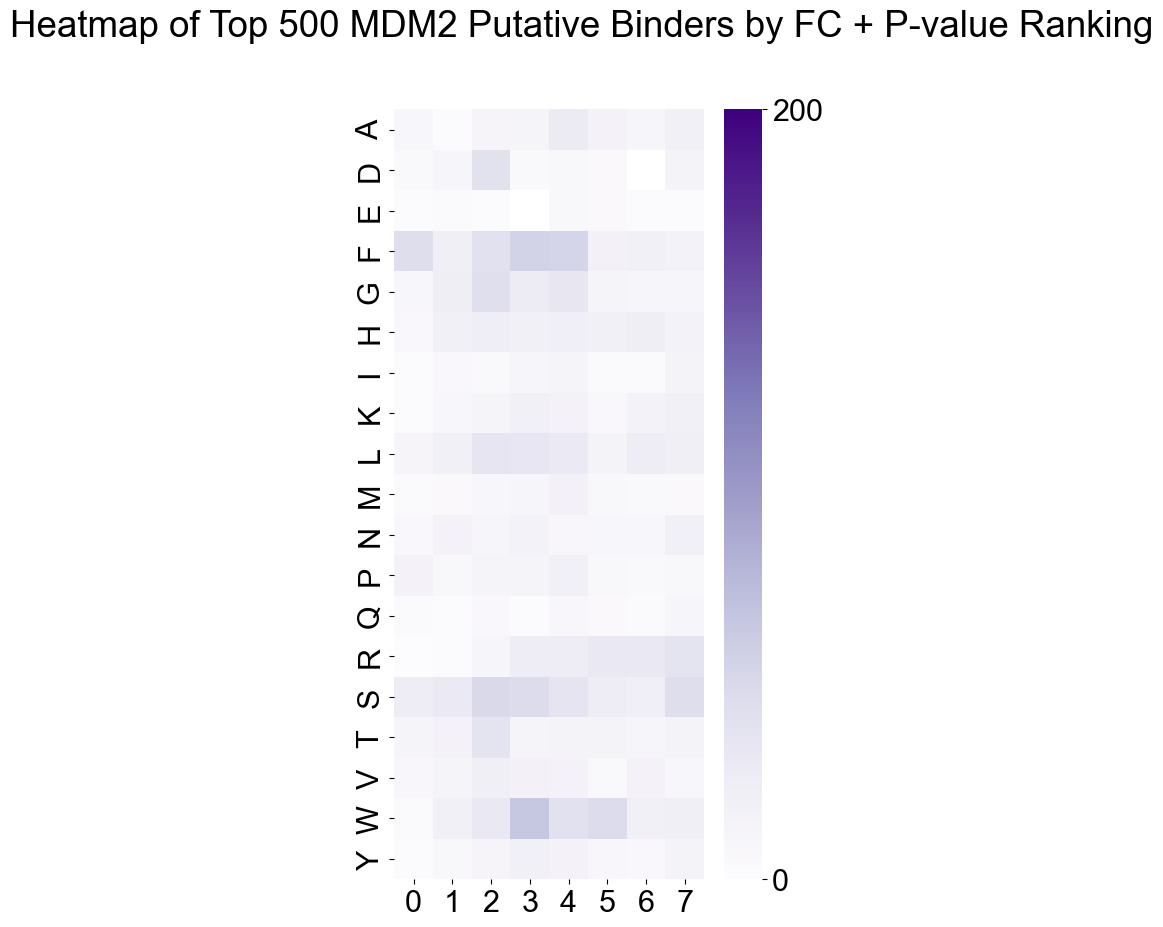

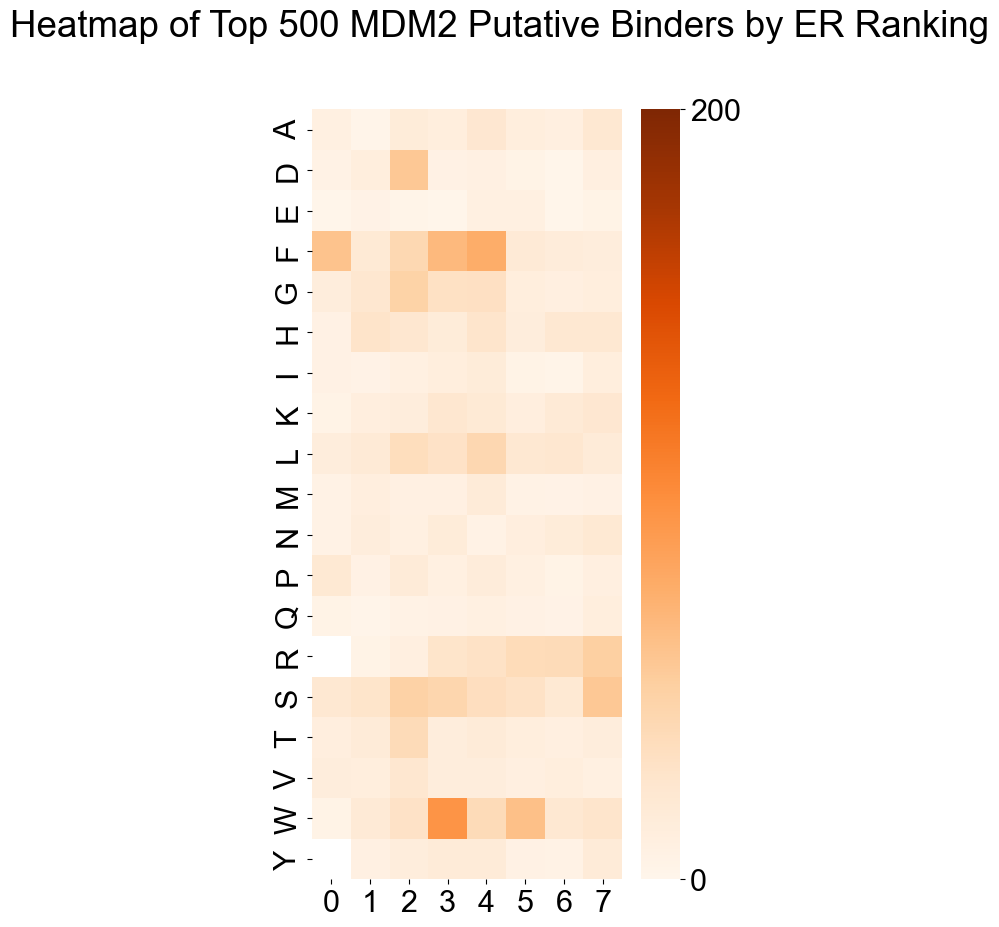

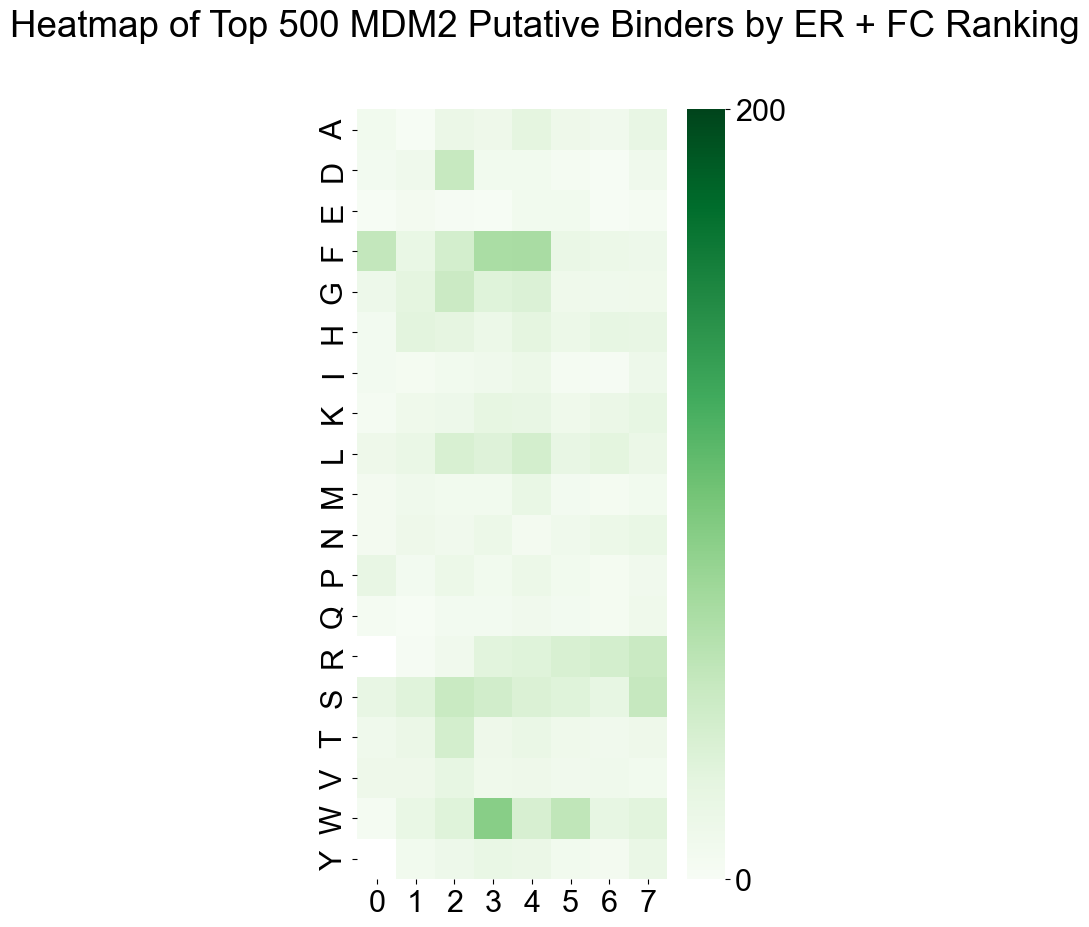

In [5]:
import analysis.heatmap_analysis as heatmap


def show_heatmap_for_top_k(title, ordering, color, peptides=peptides, top_k=top_k_size): #top_k_size=500 for MDM2
    top_k_mask = ordering >= np.partition(ordering, kth=-top_k)[-top_k]
    top_k_peptides = [pep for pep, mask in zip(peptides, top_k_mask) if mask]
    print(top_k_peptides[0])

    heatmap.generate_heatmap(
        top_k_peptides, #list of the peptide AA sequence
        title=title, #title
        vmax=200 if protein_of_interest == 'MDM2' else 600,
        colormap=color,
    )

show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by FC Ranking", fc_alone_mdm2_ordering, 'Blues')
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by FC + P-value Ranking", volcano_ordering, 'Purples')
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by ER Ranking", er_mdm2_ordering, 'Oranges')
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by ER + FC Ranking", er_fc_joint_mdm2_ordering, 'Greens')

## BiLSTM Ranking

In [6]:
print(X.shape)
print(len(FEATURE_LIST))
flatX = X.reshape(32911, 518, order='F')
print(flatX.shape)

# Expand feature names by appending _T1 to _T14
expanded_feature_names = [f"{feat}_I{t+1}" for feat in FEATURE_LIST for t in range(14)]

# Convert to DataFrame with correct column names
df_flatX = pd.DataFrame(flatX, columns=expanded_feature_names)

# Display the first few rows
df_flatX.head()


(32911, 14, 37)
37
(32911, 518)


,Pro2Vec_I1,Pro2Vec_I2,Pro2Vec_I3,Pro2Vec_I4,Pro2Vec_I5,Pro2Vec_I6,Pro2Vec_I7,Pro2Vec_I8,Pro2Vec_I9,Pro2Vec_I10,...,X_one_hot_I5,X_one_hot_I6,X_one_hot_I7,X_one_hot_I8,X_one_hot_I9,X_one_hot_I10,X_one_hot_I11,X_one_hot_I12,X_one_hot_I13,X_one_hot_I14
0,0.617256,0.565917,0.642239,0.549884,0.578843,0.571337,0.617256,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.617256,0.656186,0.479315,0.563522,0.626696,0.711738,0.592993,0.672938,0.617256,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.617256,0.621399,0.660575,0.648406,0.737923,0.611023,0.450148,0.647877,0.617256,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.617256,0.612884,0.665633,0.711484,0.749940,0.446296,0.466988,0.567812,0.617256,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.617256,0.664713,0.644989,0.619406,0.654485,0.685621,0.657019,0.643249,0.617256,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
cross_validation_results = experiment.Experiment().run_cross_validation_experiment(
    X=X,
    y=y_raw,
    model_architecture=partial(
        rnn.ThreeChannelRegressionRNN_gelu, loss=multi_channel_mse, width=64
    ),
    optimizer=partial(
        keras.optimizers.Adam, learning_rate=0.0005, weight_decay=0.5
    ),
    n_splits=10,
    load_trained_model=True,
    model_save_name=model_save_name,
    normalize=True,
    batch_size=128,
    num_epochs=5,
)


In [ ]:
bilstm_ordering, y_pred = benchmark_cross_validated_hit_rate(
    cross_validation_results=cross_validation_results,
    y_raw=y_raw,
    peptides=peptides,
    proxy_ranking_lambda=proxy_ranking_lambda,
    top_k_size=top_k_size,
    motif_dectection_func=motif_dectection_func,
)


In [ ]:
print(y_raw.shape)

# Convert y_raw to DataFrame if it's a NumPy array
if not isinstance(y_raw, pd.DataFrame):
    y_raw = pd.DataFrame(y_raw, columns=["p-value", "FC", "ER"])  # Assign custom column names

# Plot histograms for each column
fig, axes = plt.subplots(1, y_raw.shape[1], figsize=(15, 5))  # Create subplots

for i, column in enumerate(y_raw.columns):
    axes[i].hist(y_raw[column], bins=30, edgecolor="black", alpha=0.7)
    axes[i].set_title(f"Histogram of {column}")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by BiLSTM Ranking", bilstm_ordering, 'Reds')

## Benchmark

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(12, 12), dpi=80)

rankings=[
(
    bilstm_ordering, 'BiLSTM Model Ranking', '#F94040'
),
(
    er_mdm2_ordering, 'ER Ranking', '#D55E00'
),
(
    er_fc_joint_mdm2_ordering, 'Joint ER/FC Ranking', '#0F980F'
),
(
    volcano_ordering, 'Joint FC/Pval Ranking', '#5757F9'
),
(
    fc_alone_mdm2_ordering, 'FC Ranking', '#56B4E9'
),
]

In [ ]:
print(len(peptides))

# Create a DataFrame
df = pd.DataFrame(list(zip(peptides, bilstm_ordering)), columns=["Peptides", "BiLSTM Ordering"])

df_unordered = pd.concat([df, df_flatX], axis=1)
df_sorted = df_unordered.sort_values(by="BiLSTM Ordering", ascending=False).reset_index(drop=True)

# Print the first 10 rows
print(df_sorted.head(3))
print(df_unordered.head(3))


# Create Fastas and Run Xstreme Motif Finder on BiLSTM results

In [ ]:
### Makes fasta of top 1% according to BiLSTM model

# Define output file path
Top_Percent_fasta = "MDM2_1percent.fasta"
All_fasta = "Whole.fasta"

import random

expected_freqs = {
    'A': 2/32, 'C': 1/32, 'D': 1/32, 'E': 1/32, 'F': 1/32,
    'G': 2/32, 'H': 1/32, 'I': 1/32, 'K': 1/32, 'L': 3/32,
    'M': 1/32, 'N': 1/32, 'P': 2/32, 'Q': 2/32, 'R': 3/32,
    'S': 3/32, 'T': 2/32, 'V': 2/32, 'W': 1/32, 'Y': 1/32
}


amino_acids = list(expected_freqs.keys())
weights = list(expected_freqs.values())

def trim_sequence(s):
    if isinstance(s, str):
        if len(s) == 10 and s.startswith("AC"):
            return s[1:]
        elif len(s) == 9 and s.startswith("A"):
            return s[1:]
        elif len(s) == 7:
            rand_aa = random.choices(amino_acids, weights=weights, k=1)[0]
            return rand_aa + s
    return s

df_trimmed_BiLSTM = df_sorted.iloc[:, 0].astype(str).apply(trim_sequence).copy()
df_trimmed_unordered = df_unordered.iloc[:, 0].astype(str).apply(trim_sequence).copy()

_ = SL_Xstreme.makeFasta(Top_Percent_fasta, df_trimmed_BiLSTM.iloc[0:330])

_ = SL_Xstreme.makeFasta(All_fasta, df_trimmed_unordered)


In [ ]:
background_file_path = "xstreme_output/ShuffledBackground.txt"
bg_file = SL_Xstreme.create_protein_background(All_fasta, background_file_path)

In [ ]:
# Run Xstreme
temp_fasta = "MDM2_1percent.fasta"
background = "xstreme_output/ShuffledBackground.txt" #default is going to be either all equal or shuffled input
output_folder = "xstreme_output"
minw = 3
maxw = 7

SL_Xstreme.run_xstreme_docker(temp_fasta, output_folder, minw, maxw, background)

In [ ]:
# 
import shutil
streme_xml = "xstreme_output/streme_out/streme.xml"
background_file = "xstreme_output/ShuffledBackground.txt"
peptide_fasta = "Whole.fasta"
output_base_dir = "fimo_results_all"

# ✅ Clear the top-level output directory if it exists
if os.path.exists(output_base_dir):
    shutil.rmtree(output_base_dir)
    print(f"🧹 Cleared existing directory: {output_base_dir}")


_ = SL_Xstreme.motifFIMO(output_base_dir, streme_xml, background_file, peptide_fasta)

In [ ]:
# Base directory containing FIMO result folders
fimo_base_dir = "fimo_results_all"

# List to hold individual FIMO DataFrames
fimo_dfs = []

# Loop through FIMO subfolders and collect result tables
for folder in os.listdir(fimo_base_dir):
    subdir = os.path.join(fimo_base_dir, folder)
    fimo_file = os.path.join(subdir, "fimo.tsv")

    if os.path.isfile(fimo_file):
        df = pd.read_csv(fimo_file, sep='\t', comment='#')
        df['motif_source'] = folder  # Optional: add source info
        fimo_dfs.append(df)

# Assume `fimo_dfs` is your list of DataFrames
# Check that each DataFrame has the correct columns
required_columns = {'sequence_name', 'q-value', 'motif_source'}
for i, df in enumerate(fimo_dfs):
    if not required_columns.issubset(df.columns):
        raise ValueError(f"Missing required columns in dataframe {i}")
        
# Concatenate all DataFrames into one
fimo_combined_df = pd.concat(fimo_dfs, ignore_index=True)
# Optional: sort by q-value if you're interested in best hits
fimo_combined_df.sort_values(by='q-value', inplace=True)
    
# Start with all values set to NaN so we can identify sequences with no hits
FIMO_rank = np.full(df_sorted.shape[0], np.nan)

#fimo_combined_df.reset_index(drop=True, inplace=True)
fimo_combined_df['sequence_name'] = fimo_combined_df['sequence_name'].str.replace('seq_', '', regex=False).astype(int)

print(fimo_combined_df)


In [ ]:
# Step 1: Make sure sequence_name is int (already appears to be)
fimo_combined_df['sequence_name'] = fimo_combined_df['sequence_name'].astype(int)

# Step 2: Get the best (lowest) q-value per sequence_name (i.e., peptide index)
min_qvals = fimo_combined_df.groupby('sequence_name')['q-value'].min()

# Step 3: Initialize a Series with q=1 for all indices in df_sorted
fimo_rank = pd.Series(1.0, index=df_unordered.index)

# Step 4: Overwrite available indices with their actual q-values from FIMO
fimo_rank.update(min_qvals)

# Step 5: Optional: log-transform q-values for ranking (e.g., -log10)
# Replace 0s (if any) to avoid log errors
fimo_rank = -np.log10(fimo_rank.replace(0, np.nextafter(0, 1)))

# Step 6: Add FimoRank to df_sorted as the 3rd column
FimoDF = df_unordered.copy()
FimoDF.insert(2, 'FimoRank', fimo_rank)

# Sort by FimoRank descending (i.e., best hits on top)
FimoDF = FimoDF.sort_values(by="FimoRank", ascending=False).reset_index(drop=True)

# Preview top 100
print(FimoDF.head(100))
print(fimo_rank)

In [ ]:
# Create histogram
plt.figure(figsize=(8, 6))
plt.hist(df_sorted["BiLSTM Ordering"], bins=30, edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel("BiLSTM Ordering")
plt.ylabel("Frequency")
plt.title("Histogram of BiLSTM Ordering")

# Show plot
plt.show()

count = (df_sorted["BiLSTM Ordering"] > 3.874).sum()
print(f"Number of peptides with BiLSTM Ordering > 3.874: {count}")


## Check PCA Variance

In [ ]:
##### PCA clustering
start_col = df_sorted.columns.get_loc("A_one_hot_I1")
print(start_col)
df_numeric = df_sorted.iloc[:330, start_col:].copy()

print(df_numeric)
num_pc = SL_PCA.perform_pca_variance_analysis(df_numeric, L2norm=False)

In [ ]:
##### PCA clustering
start_col = df_sorted.columns.get_loc("A_one_hot_I1")
print(start_col)
df_numeric = df_sorted.iloc[:, start_col:].copy()

num_pc = SL_PCA.perform_pca_variance_analysis(df_numeric, L2norm=False)

In [ ]:
# PCA scores and Loadings for Top 1%
L2norm = False

start_col = df_sorted.columns.get_loc("A_one_hot_I1")
df_numeric_1percent = df_sorted.iloc[:330, start_col:].copy()
df_1_percent_peptides = df_sorted.iloc[0:330, 0].copy()

# Perform PCA
if L2norm: 
    df_numeric_1percent = normalize(df_numeric_1percent, norm="l2")  # L2 normalization

pca = PCA(n_components=2)
pc_values = pca.fit_transform(df_numeric_1percent)
loadings = pca.components_.T  # Loadings matrix (shape: features × PCs)

# Create DataFrame for scores
df_pca = pd.DataFrame(pc_values, columns=["PC1", "PC2"])
df_pca["Peptides"] = df_1_percent_peptides

# Create DataFrame for loadings
df_loadings = pd.DataFrame(loadings, columns=["PC1", "PC2"], index=df_numeric_1percent.columns)

# ---- Plot PCA Scores (Scatterplot) ----
plt.figure(figsize=(10, 8))
sns.scatterplot(x="PC1", y="PC2", data=df_pca, alpha=0.7)

for i, row in df_pca.iterrows():
    plt.text(row["PC1"], row["PC2"], row["Peptides"], fontsize=8, ha="right", va="bottom")

plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.title("PCA Scores: Peptides in PC1 vs PC2 Space")
plt.grid(True)
plt.show()

# ---- Plot PCA Loadings (Biplot Style) ----
plt.figure(figsize=(10, 8))
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)

sns.scatterplot(x="PC1", y="PC2", data=df_loadings, alpha=0.7, color='red')

for i, row in df_loadings.iterrows():
    plt.text(row["PC1"], row["PC2"], row.name, fontsize=8, ha="right", va="bottom")

plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.title("PCA Loadings: Variable Contributions to PCs")
plt.grid(True)
plt.show()

In [ ]:
##### PCA on top 1%

start_col = df_sorted.columns.get_loc("A_one_hot_I1")
df_numeric_1percent = df_sorted.iloc[:330, start_col:].copy()
print(df_numeric_1percent.shape)

if L2norm: 
    df_numeric_1percent = normalize(df_numeric_1percent, norm="l2")  # L2 normalization

# Perform PCA, reducing to 70 principal components
pca = PCA(n_components=70)
pc_values = pca.fit_transform(df_numeric_1percent)

# Create a DataFrame with PC1 and PC2
df_pca = pd.DataFrame(pc_values)

print(df_pca.shape)


In [ ]:
# Evalueate Kmeans clustering on df_pca of top 1%
inertia, sil_scores = SL_PCA.evaluate_clustering(df_pca, cluster_range=range(2, 20), method='kmeans')

In [ ]:
# Does Kmeans clustering on top 1% without PCA

L2norm = False

start_col = df_sorted.columns.get_loc("A_one_hot_I1")
df_features = df_sorted.iloc[:330, start_col:].copy()

# Drop the first two columns (assuming they are non-numeric)
if L2norm: 
    df_features = normalize(df_features, norm="l2")  # L2 normalization
    
df_1_percent_peptides = df_sorted.iloc[:330, 0].copy()
print(df_1_percent_peptides.shape)

inertia, sil_scores = SL_PCA.evaluate_clustering(df_features, cluster_range=range(2, 20), method='kmeans')


In [ ]:
df_pca_kmed = df_pca.copy()

inertia, sil_scores = SL_PCA.evaluate_clustering(df_pca_kmed, cluster_range=range(2, 20), method='kmedoids')

In [ ]:
# Perform K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=100)
cluster_labels = kmeans.fit_predict(df_pca)

# Make a new DataFrame that includes cluster labels
df_pca_with_cluster = df_pca.copy()
df_pca_with_cluster["K-means_Cluster"] = cluster_labels
print(df_pca_with_cluster.head(11))

In [ ]:
##### df_pca kmeans clustering

# Ensure 'Cluster' is included separately for grouping
cluster_means_pca = df_pca_with_cluster.groupby("K-means_Cluster").mean()  # Compute mean one-hot encoding
print(f"Shape of cluster_means: {cluster_means_pca.shape}")
print(cluster_means_pca)

# Inverse transform PCA-reduced cluster means back to approximate one-hot encoding
approx_one_hot_pca = pca.inverse_transform(cluster_means_pca)
print('inverse_pca ',approx_one_hot_pca.shape)
approx_one_hot_pca = np.array(approx_one_hot_pca)

approx_one_hot_df_pca = pd.DataFrame(approx_one_hot_pca, index=cluster_means_pca.index)
print(f"Shape of approximated one-hot encoding: {approx_one_hot_df_pca.shape}")
print(approx_one_hot_df_pca)

# Define amino acids and peptide sequence length
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
num_amino_acids = len(amino_acids)
seq_length = approx_one_hot_df_pca.shape[1] // num_amino_acids  # Determine peptide length
print(f"Determined sequence length: {seq_length}")

def one_hot_to_sequence(mean_one_hot):
    """Convert mean one-hot encoding back to an approximate peptide sequence."""
    sequence = []
    for i in range(seq_length):
        # Extract one-hot encoding for this position
        pos_one_hot = mean_one_hot[i * num_amino_acids : (i + 1) * num_amino_acids]
        
        # Get the most probable amino acid
        most_likely_aa = amino_acids[np.argmax(pos_one_hot)]  
        sequence.append(most_likely_aa)
    
    return "".join(sequence)

# Apply one-hot_to_sequence to each cluster row
average_sequences_pca = {cluster: one_hot_to_sequence(approx_one_hot_df_pca.loc[cluster].values) 
                     for cluster in cluster_means_pca.index}

cluster_mean_AA_pca = average_sequences_pca
print('Cluster_means_pca ',cluster_mean_AA_pca)

# Print the average peptide sequences for each cluster
for cluster, avg_seq in average_sequences_pca.items():
    print(f"Cluster {cluster}: {avg_seq}")

# Count the number of members in each cluster
print(df_pca_with_cluster["K-means_Cluster"].value_counts())

In [ ]:
# Perform K-means clustering with 3 clusters

start_col = df_sorted.columns.get_loc("A_one_hot_I1")
df_1_percent_peptides = df_sorted.iloc[:330, 0].copy()

kmeans = KMeans(n_clusters=3, random_state=42, n_init=100)
cluster_labels = kmeans.fit_predict(df_sorted.iloc[:330, start_col:].copy())

# Make a new DataFrame that includes cluster labels
df_with_cluster =  df_sorted.iloc[:330, start_col:].copy()
df_with_cluster["K-means_Cluster"] = cluster_labels
print(df_with_cluster.head())

In [ ]:
# Non-PCA

# Ensure 'Cluster' is included separately for grouping
cluster_means = df_with_cluster.groupby("K-means_Cluster").mean()  # Compute mean one-hot encoding
print(f"Shape of cluster_means: {cluster_means.shape}")
print(cluster_means)

approx_one_hot = np.array(cluster_means)


approx_one_hot_df = pd.DataFrame(approx_one_hot, index=cluster_means.index)
print(f"Shape of approximated one-hot encoding: {approx_one_hot_df.shape}")
print(approx_one_hot_df)

# Count the number of members in each cluster
print(df_with_cluster["K-means_Cluster"].value_counts())


approx_one_hot_df_pca = pd.DataFrame(approx_one_hot_pca, index=cluster_means_pca.index)
print(f"Shape of approximated one-hot encoding: {approx_one_hot_df_pca.shape}")
print(approx_one_hot_df_pca)

# Define amino acids and peptide sequence length
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
num_amino_acids = len(amino_acids)
seq_length = approx_one_hot_df_pca.shape[1] // num_amino_acids  # Determine peptide length
print(f"Determined sequence length: {seq_length}")

def one_hot_to_sequence(mean_one_hot):
    """Convert mean one-hot encoding back to an approximate peptide sequence."""
    sequence = []
    for i in range(seq_length):
        # Extract one-hot encoding for this position
        pos_one_hot = mean_one_hot[i * num_amino_acids : (i + 1) * num_amino_acids]
        
        # Get the most probable amino acid
        most_likely_aa = amino_acids[np.argmax(pos_one_hot)]  
        sequence.append(most_likely_aa)
    
    return "".join(sequence)

# Apply one-hot_to_sequence to each cluster row
average_sequences_pca = {cluster: one_hot_to_sequence(approx_one_hot_df_pca.loc[cluster].values) 
                     for cluster in cluster_means_pca.index}

cluster_mean_AA_pca = average_sequences_pca
print('Cluster_means_pca ',cluster_mean_AA_pca)

# Print the average peptide sequences for each cluster
for cluster, avg_seq in average_sequences_pca.items():
    print(f"Cluster {cluster}: {avg_seq}")

# Count the number of members in each cluster
print(df_pca_with_cluster["K-means_Cluster"].value_counts())

In [ ]:
# Non-PCA skip

start_col = df_sorted.columns.get_loc("A_one_hot_I1")
df_1_percent_peptides = df_sorted.iloc[:330, 0].copy()

df_1_p_features = df_sorted.iloc[:330, start_col:].copy()

kmeans = KMeans(n_clusters=3, random_state=42, n_init=100)


# Perform K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=100)
cluster_labels = kmeans.fit_predict(df_1_p_features)

# Make a new DataFrame that includes cluster labels
df_with_cluster = df_1_p_features.copy()

if L2norm: 
    df_with_clustersNorm = normalize(df_with_cluster, norm="l2")  # L2 normalization
    df_with_cluster["K-means_Cluster"] = kmeans.fit_predict(df_with_clusterNorm)
else:
# Perform K-means clustering with 3 clusters
    df_with_cluster["K-means_Cluster"] = kmeans.fit_predict(df_with_cluster)
    
print(df_with_cluster.head())

"""
kmedoids = KMedoids(n_clusters=6, metric='cosine', random_state=42)
df_1_p_features["Cluster"] = kmedoids.fit_predict(df_1_p_features)
print(df_1_p_features)
"""
# Save the results (optional)
#df_trimmed_one_hot.to_csv("peptides_clustered.csv", index=False)

#print("K-means clustering complete. Cluster labels added to 'peptides_clustered.csv'.")

In [ ]:
#Non-PCA

# Get only one-hot encoding columns (excluding first two cols and 'Cluster')
Top_1_with_cluster = df_with_cluster.copy()
print(f"Shape of Top_1_with_cluster: {Top_1_with_cluster.shape}")

Full_Trimmed_one_hot = df_unordered.iloc[:, 225:].copy()
print(f"Shape of Full_Trimmed_one_hot: {Full_Trimmed_one_hot.shape}")

# Ensure 'Cluster' is included separately for grouping
cluster_means = Top_1_with_cluster.groupby("K-means_Cluster").mean()  # Compute mean one-hot encoding
print(f"Shape of cluster_means: {cluster_means.shape}")
print(cluster_means.head(5))

# Define amino acids and peptide sequence length
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
num_amino_acids = len(amino_acids)
seq_length = cluster_means.shape[1] // num_amino_acids  # Determine peptide length
print(f"Determined sequence length: {seq_length}")

def one_hot_to_sequence(mean_one_hot):
    """Convert mean one-hot encoding back to an approximate peptide sequence."""
    sequence = []
    for i in range(seq_length):
        # Extract one-hot encoding for this position
        pos_one_hot = mean_one_hot.iloc[i * num_amino_acids : (i + 1) * num_amino_acids].values
        
        # Check if the one-hot encoding is correctly structured
        if len(pos_one_hot) != num_amino_acids:
            print(f"Warning: Unexpected length at position {i}: {len(pos_one_hot)}")
            continue
        
        # Get the most probable amino acid
        most_likely_aa = amino_acids[np.argmax(pos_one_hot)]  
        sequence.append(most_likely_aa)
    
    return "".join(sequence)

# Generate average peptide sequence for each cluster
average_sequences = cluster_means.apply(one_hot_to_sequence, axis=1)

# Print the average peptide sequences
for cluster, avg_seq in zip(cluster_means.index, average_sequences):
    print(f"Cluster {cluster}: {avg_seq}")
    
Top_1_with_cluster["K-means_Cluster"].value_counts()

In [ ]:
# Convert to NumPy arrays
peptide_encodings = np.array(df_unordered.iloc[:, 226:]).copy()  

# Ensure cluster_means is a NumPy array
if isinstance(cluster_means, dict):
    raise TypeError("Error: 'cluster_means' is a dictionary. Convert it to a NumPy array or DataFrame.")
cluster_means_array = np.array(cluster_means)
cluster_means_array_pca = np.array(approx_one_hot_pca) 

# Function to compute Pearson correlation efficiently
def compute_pearson_matrix(peptides, clusters):
    return np.array([[pearsonr(peptide, cluster)[0] for cluster in clusters] for peptide in peptides])

# Function to compute similarity metrics
def compute_similarity_metrics(peptides, clusters):
    return {
        #"Pearson": compute_pearson_matrix(peptides, clusters),
        "Cosine": cosine_similarity(peptides, clusters),
        "Euclidean": -cdist(peptides, clusters, metric='euclidean')  # Negative for similarity convention
    }

# Compute similarities for both normal and PCA cluster means
similarity_results = {metric: compute_similarity_metrics(peptide_encodings, clusters)
                      for metric, clusters in {"K_means Normal": cluster_means_array, "K_means PCA": cluster_means_array_pca}.items()}

# Convert similarity scores to DataFrames
df_similarity = {}
for metric, results in similarity_results.items():
    for sim_type, scores in results.items():
        df_similarity[f"{sim_type}_{metric}"] = pd.DataFrame(scores, 
            columns=[f"Similarity_to_Cluster_{i}" for i in range(scores.shape[1])])

# Create DataFrame for best similarity scores and their corresponding clusters
df_re_ranked = df_unordered.iloc[:,226:].copy()

for key, df in df_similarity.items():
    df_re_ranked[f"Max_{key}"] = df.max(axis=1)  # Highest similarity score
    df_re_ranked[f"Best_{key}_Cluster"] = df.idxmax(axis=1)  # Best-matching cluster

# Print top-ranked peptides
print(df_re_ranked.head())

In [ ]:
###skip

# Create a copy to avoid modifying the original DataFrame
df_index = df_re_ranked.copy()
df_index_pca = df_re_ranked_pca.copy()
print(df_index_pca.head())

# Rank peptides by BiLSTM Ordering (highest BiLSTM Ordering = rank 1)
df_index['BiLSTM_Rank'] = df_index['BiLSTM Ordering'].rank(ascending=False, method='first')
df_index_pca['BiLSTM_Rank'] = df_index_pca['BiLSTM Ordering'].rank(ascending=False, method='first')

# Sort the entire DataFrame based on BiLSTM Rank
#df_index = df_index.sort_values(by='BiLSTM_Rank').reset_index(drop=True)

# Select first 500 peptides to plot (you can adjust this based on your needs)
df_plot = df_index.iloc[:500].copy()

# Plotting the comparison
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_plot['Max_Similarity_Score'], y=df_plot['BiLSTM_Rank'], alpha=0.7)

# Labels and title
plt.xlabel("Peptide Index by Similarity Score")
plt.ylabel("Peptide Index by BiLSTM Ordering")
plt.title("Peptide Index Comparison: Similarity Score vs BiLSTM Ordering (Top 500 Peptides)")
plt.grid(True)

# Show plot
plt.show()

print(df_index_pca.head())

In [ ]:
# Create copies of the original DataFrames
df_resorted = df_re_ranked.copy()

# Extract all similarity score columns dynamically
similarity_columns = [col for col in df_resorted.columns if "Max" in col]

# Dictionary to store K-means ordering values
KmeansSL_orderings = {col: df_resorted[col].values for col in similarity_columns}

# Print keys to verify
print("K-means Orderings:", KmeansSL_orderings.keys())

In [ ]:
from matplotlib.pyplot import figure

# Set figure size and DPI
figure(figsize=(12, 12), dpi=80)

# Define static rankings, but start with XSTREME
rankings = [
    (fimo_rank, "XSTREME_Ranking", "#5757F9"),
]

# Add ONLY 'Max_Cosine_K_means PCA' from the K-means results
if 'Max_Cosine_K_means PCA' in KmeansSL_orderings:
    rankings.append((
        KmeansSL_orderings['Max_Cosine_K_means PCA'],
        'Max_Cosine_K_means PCA',
        "#E69F00"  # Or any custom color you like
    ))

# Add the rest of the static rankings
rankings.extend([
    (bilstm_ordering, "BiLSTM Model Ranking", "#F94040"),
    (er_mdm2_ordering, 'ER Ranking', '#D55E00'),
    (er_fc_joint_mdm2_ordering, "Joint ER/FC Ranking", "#0F980F"),
    (volcano_ordering, "Joint FC/Pval Ranking", "#5757F9"),
    (fc_alone_mdm2_ordering, 'FC Ranking', '#56B4E9')
])

# Confirm final order and content
print("Included Ranking Keys in Legend:")
for _, label, _ in rankings:
    print(label)

In [ ]:
plot_ratio_by_ranking(
    peptides=peptides,
    y_rankings=rankings,
    title="",
    peptide_dataset_size=top_k_size,
    hit_rate_func=seq_contains_mdm2_motif if protein_of_interest =="MDM2" else seq_contains_12ca5_motif,
    save_file='mdm2_hit_rankings.csv' if protein_of_interest =='MDM2' else '12ca5_hit_rankings.csv',
)

In [ ]:
from utils.utils import seed_everything
seed_everything(0)
num_combinations = 100

print(y_raw.shape)
y_raw = np.array(y_raw)

# Generate random positive coefficients
coefficients = np.random.rand(num_combinations, 2)  
coefficients /= coefficients.sum(axis=1, keepdims=True)  # Normalize to sum to 1
#print("Generated coefficients:\n", coefficients)

optim_orderings = {}  # Store ranking results
auc_scores = []  # Store (AUC, weight) pairs

# Compute orderings for each coefficient set
for i, (w2, w1) in enumerate(coefficients):
    optim_orderings[f"combination_{i}"] = [w2 * y[2] + w1 * y[1] for y in y_raw] #w2=ER,w1=

# Iterate through all orderings and compute AUC
for i, (ranking_name, ordering) in enumerate(optim_orderings.items()):
    
    # Define the ranking structure
    rankings = [(ordering, ranking_name, '#0F980F')]

    # Compute AUC
    auc_value = plot_ratio_by_ranking(
        peptides=peptides,
        y_rankings=rankings,
        title="",
        peptide_dataset_size=top_k_size,
        hit_rate_func=seq_contains_mdm2_motif if protein_of_interest == "MDM2" else seq_contains_12ca5_motif,
        save_file='mdm2_hit_rankings.csv' if protein_of_interest == 'MDM2' else '12ca5_hit_rankings.csv',
    )
    
    # Store AUC with corresponding weights
    auc_scores.append((auc_value, coefficients[i]))

# Find the best AUC and corresponding weights
best_auc, best_weights = max(auc_scores, key=lambda x: x[0])

print(f"Best AUC: {best_auc:.4f}")
print(f"Best Weights: w2={best_weights[0]:.4f}, w1={best_weights[1]:.4f}, w0=0")

In [ ]:
from utils.utils import seed_everything
seed_everything(0)
num_combinations = 200

# Generate random positive coefficients
coefficients = np.random.rand(num_combinations, 3)  
coefficients /= coefficients.sum(axis=1, keepdims=True)  # Normalize to sum to 1
#print("Generated coefficients:\n", coefficients)

optim_orderings = {}  # Store ranking results
auc_scores = []  # Store (AUC, weight) pairs

# Compute orderings for each coefficient set
for i, (w2, w1, w0) in enumerate(coefficients):
    optim_orderings[f"combination_{i}"] = [w2 * y[2] + w1 * y[1] + w0 * y[0] for y in y_raw] #w2=ER,w1=

# Iterate through all orderings and compute AUC
for i, (ranking_name, ordering) in enumerate(optim_orderings.items()):
    
    # Define the ranking structure
    rankings = [(ordering, ranking_name, '#0F980F')]

    # Compute AUC
    auc_value = plot_ratio_by_ranking(
        peptides=peptides,
        y_rankings=rankings,
        title="",
        peptide_dataset_size=top_k_size,
        hit_rate_func=seq_contains_mdm2_motif if protein_of_interest == "MDM2" else seq_contains_12ca5_motif,
        save_file='mdm2_hit_rankings.csv' if protein_of_interest == 'MDM2' else '12ca5_hit_rankings.csv',
    )
    
    # Store AUC with corresponding weights
    auc_scores.append((auc_value, coefficients[i]))

# Find the best AUC and corresponding weights
best_auc, best_weights = max(auc_scores, key=lambda x: x[0])

print(f"Best AUC: {best_auc:.4f}")
print(f"Best Weights: w2={best_weights[0]:.4f}, w1={best_weights[1]:.4f}, w0={best_weights[2]:.4f}")

# Now Hit Rate Benchmarking for 12ca5

In [3]:
protein_of_interest = "12ca5"
other_protein = "MDM2"

def proxy_ranking_lambda(x):
    # Proxy metric is defined as FC (y_raw[:, 1]) + ER (y_raw[:, 2])
    return 1*x[1] + 1*x[2] + 0*x[0]

top_k_size = 500 if protein_of_interest == "MDM2" else 1000
motif_dectection_func = (
    seq_contains_mdm2_motif
    if protein_of_interest == "MDM2"
    else seq_contains_12ca5_motif
)
model_save_name = (
    "trained_models/final_models/mdm2_model.h5"
    if protein_of_interest == "MDM2"
    else "trained_models/final_models/12ca5_model.h5"
)


X, y_raw, peptides, FEATURE_LIST = data_loading.build_joint_dataset(
    er_datafile=f"{protein_of_interest}_merged_ER.csv",
    volcano_datafile="12ca5-MDM2-R3.csv",
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
)


jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
12ca5 sum_x                                               0.728511
12ca5 sum_y                                               0.476673
12ca5 sum                                                 0.102793
ER                                                        2.825214
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0                        

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


(-10.735610373902963, 13.334223068602926, -0.8329379238887278, 27.369964117469774)


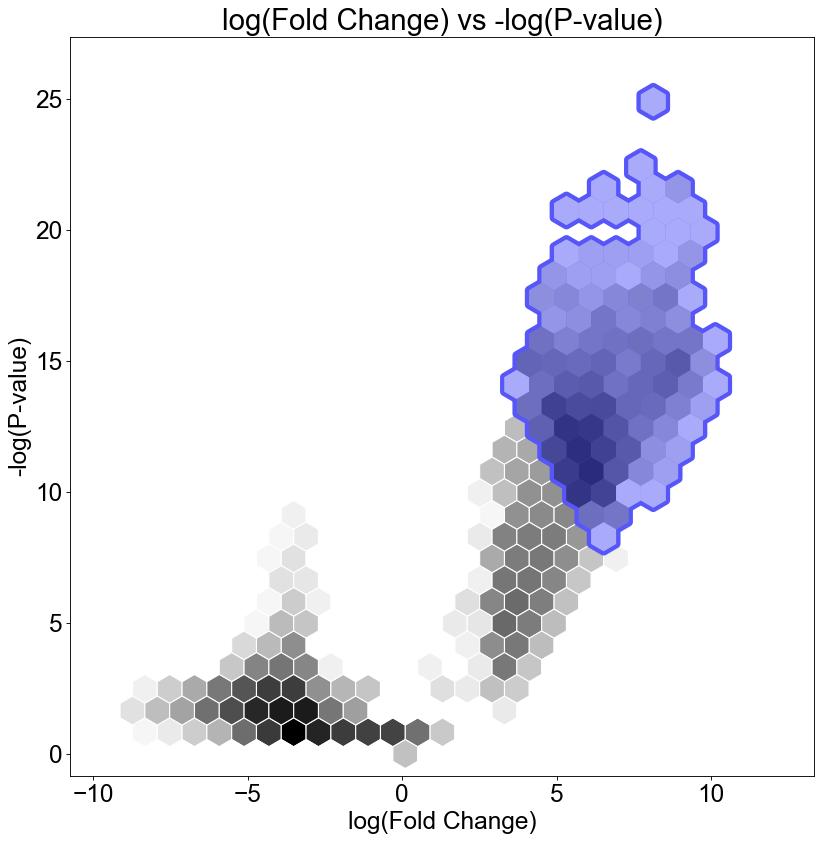

(-10.735610373902963, 13.334223068602926, -0.8329379238887278, 27.369964117469774)


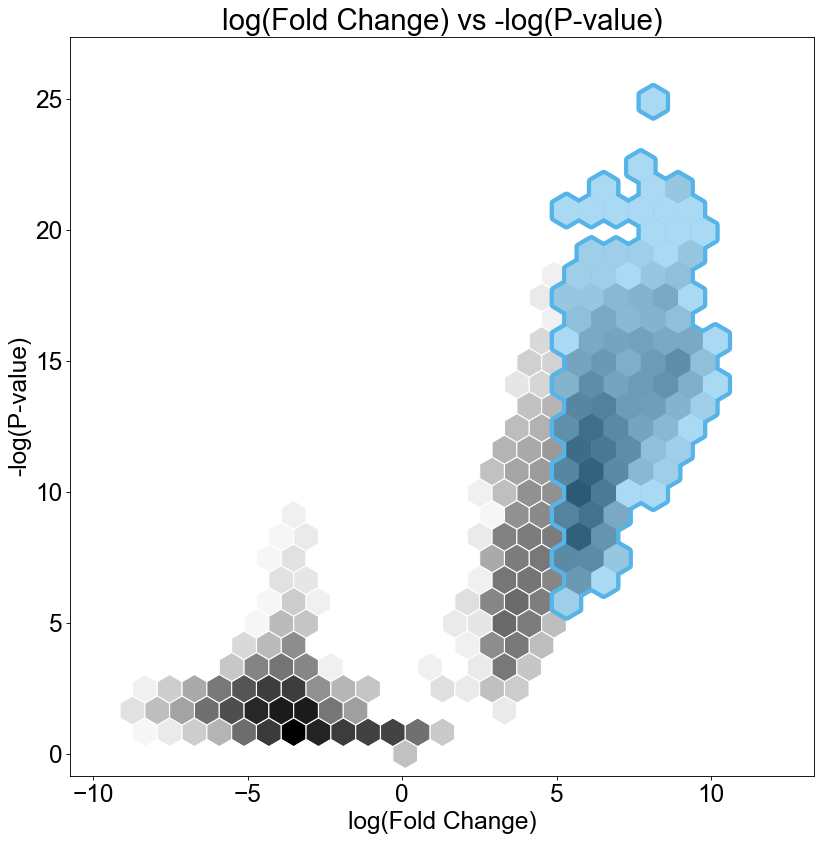

(-18.34857663886301, 12.263528443333284, -10.735610373902963, 13.334223068602926)


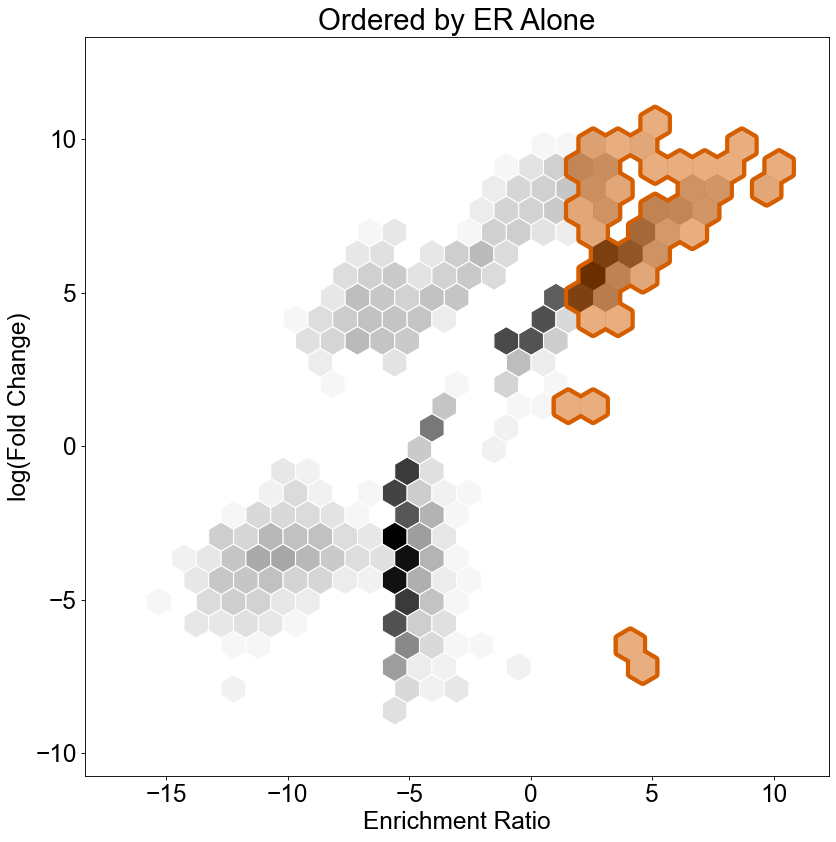

(-18.34857663886301, 12.263528443333284, -10.735610373902963, 13.334223068602926)


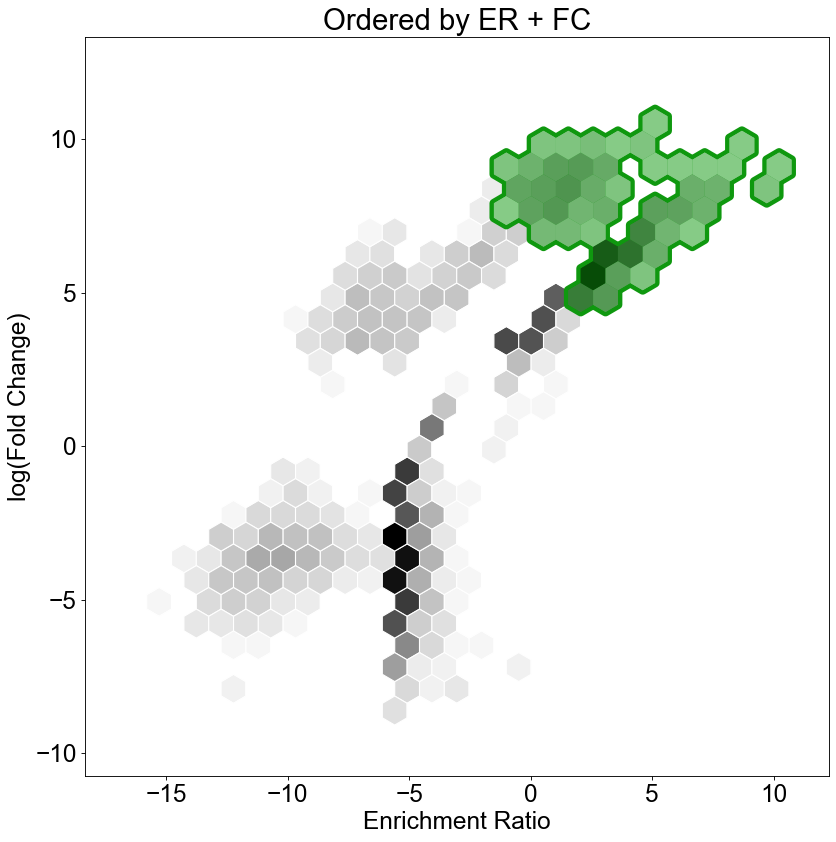

In [4]:
volcano_ordering = (
    np.array([(val[0] + 6) * val[1] if val[1] > 0 else 0 for val in y_raw])
    if protein_of_interest == "MDM2"
    else np.array([val[0] * val[1] for val in y_raw])
)
plot_fancy_hexbin_relations(
    1,
    0,
    datapoints=y_raw,
    ordering=volcano_ordering,
    all_positives=None,
    line_color='#5757F9',
    top_k=top_k_size,
)

fc_alone_mdm2_ordering = [y[1] for y in y_raw]
plot_fancy_hexbin_relations(
    1,
    0,
    datapoints=y_raw,
    ordering=fc_alone_mdm2_ordering,
    all_positives=None,
    line_color='#56B4E9',
    top_k=top_k_size,
)

er_mdm2_ordering = [y[2] for y in y_raw]

plot_fancy_hexbin_relations(
    2,
    1,
    datapoints=y_raw,
    ordering=er_mdm2_ordering,
    all_positives=None,
    line_color='#D55E00',
    title='Ordered by ER Alone',
    top_k=top_k_size,
)

er_fc_joint_mdm2_ordering = [y[2] + y[1] for y in y_raw]
plot_fancy_hexbin_relations(
    2,
    1,
    datapoints=y_raw,
    ordering=er_fc_joint_mdm2_ordering,
    all_positives=None,
    line_color='#0F980F',
    title='Ordered by ER + FC',
    top_k=top_k_size,
)

In [ ]:
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by FC Ranking", fc_alone_mdm2_ordering, 'Blues')
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by FC + P-value Ranking", volcano_ordering, 'Purples')
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by ER Ranking", er_mdm2_ordering, 'Oranges')
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by ER + FC Ranking", er_fc_joint_mdm2_ordering, 'Greens')

In [5]:
cross_validation_results = experiment.Experiment().run_cross_validation_experiment(
    X=X,
    y=y_raw,
    model_architecture=partial(
        rnn.ThreeChannelRegressionRNN_gelu, loss=multi_channel_mse, width=64
    ),
    optimizer=partial(
        keras.optimizers.Adam, learning_rate=0.0005, weight_decay=0.5
    ),
    n_splits=10,
    load_trained_model=True,
    model_save_name=model_save_name,
    normalize=True,
    batch_size=128,
    num_epochs=5,
)


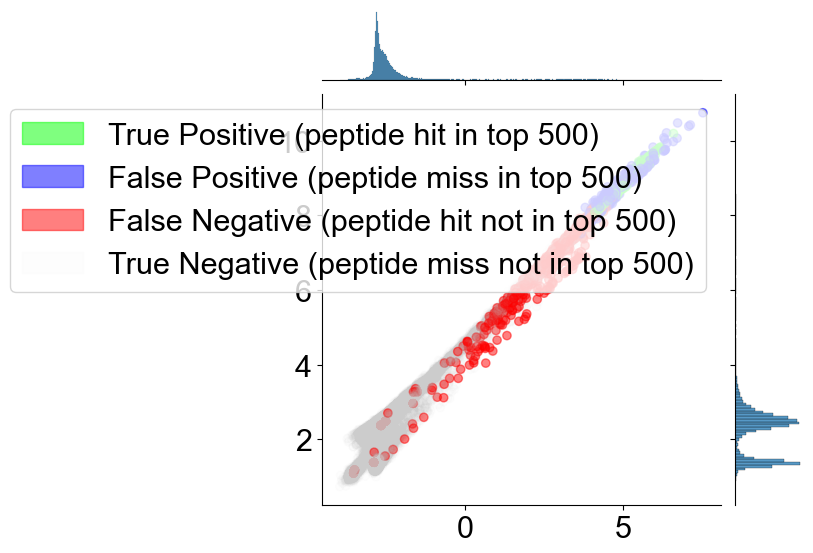

In [6]:
bilstm_ordering, y_pred = benchmark_cross_validated_hit_rate(
    cross_validation_results=cross_validation_results,
    y_raw=y_raw,
    peptides=peptides,
    proxy_ranking_lambda=proxy_ranking_lambda,
    top_k_size=top_k_size,
    motif_dectection_func=motif_dectection_func,
)

(32911, 3)


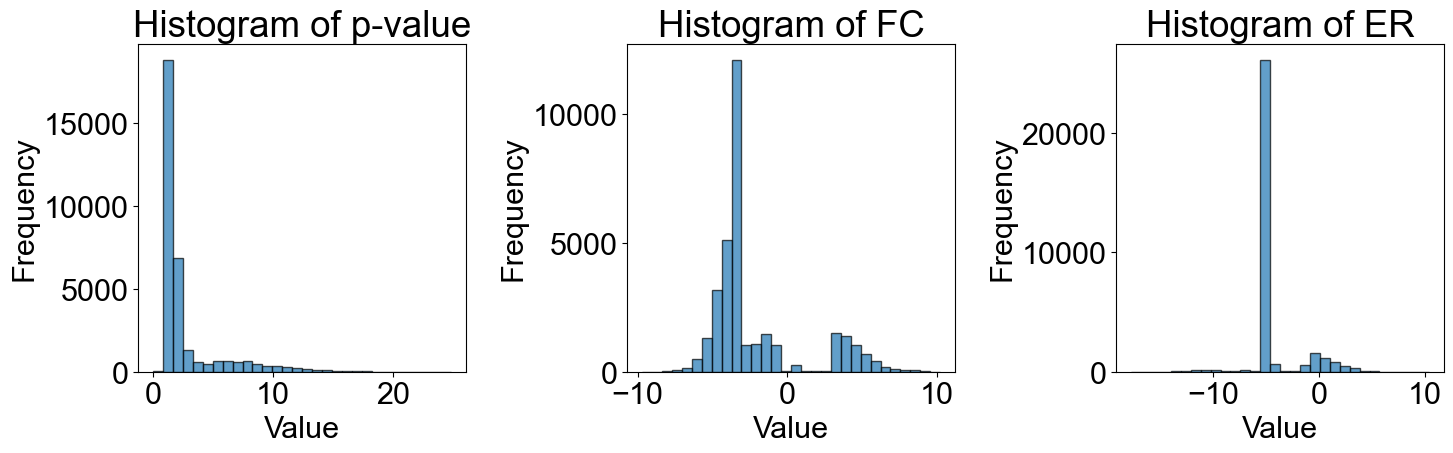

In [7]:
print(y_raw.shape)

# Convert y_raw to DataFrame if it's a NumPy array
if not isinstance(y_raw, pd.DataFrame):
    y_raw = pd.DataFrame(y_raw, columns=["p-value", "FC", "ER"])  # Assign custom column names

# Plot histograms for each column
fig, axes = plt.subplots(1, y_raw.shape[1], figsize=(15, 5))  # Create subplots

for i, column in enumerate(y_raw.columns):
    axes[i].hist(y_raw[column], bins=30, edgecolor="black", alpha=0.7)
    axes[i].set_title(f"Histogram of {column}")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [8]:
from matplotlib.pyplot import figure
figure(figsize=(12, 12), dpi=80)

rankings=[
(
    bilstm_ordering, 'BiLSTM Model Ranking', '#F94040'
),
(
    er_mdm2_ordering, 'ER Ranking', '#D55E00'
),
(
    er_fc_joint_mdm2_ordering, 'Joint ER/FC Ranking', '#0F980F'
),
(
    volcano_ordering, 'Joint FC/Pval Ranking', '#5757F9'
),
(
    fc_alone_mdm2_ordering, 'FC Ranking', '#56B4E9'
),
]

<Figure size 960x960 with 0 Axes>

In [ ]:
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by BiLSTM Ranking", bilstm_ordering, 'Reds')

In [9]:
print(len(peptides))

print(X.shape)
print(len(FEATURE_LIST))
flatX = X.reshape(32911, 518, order='F')
print(flatX.shape)

# Expand feature names by appending _T1 to _T14
expanded_feature_names = [f"{feat}_I{t+1}" for feat in FEATURE_LIST for t in range(14)]

# Convert to DataFrame with correct column names
df_flatX = pd.DataFrame(flatX, columns=expanded_feature_names)

# Display the first few rows
df_flatX.head()

# Create a DataFrame
df = pd.DataFrame(list(zip(peptides, bilstm_ordering)), columns=["Peptides", "BiLSTM Ordering"])

df_unordered = pd.concat([df, df_flatX], axis=1)
df_sorted = df_unordered.sort_values(by="BiLSTM Ordering", ascending=False).reset_index(drop=True)

# Print the first 10 rows
print(df_sorted.head())
print(df_unordered.head())


32911
(32911, 14, 37)
37
(32911, 518)
    Peptides  BiLSTM Ordering  Pro2Vec_I1  Pro2Vec_I2  Pro2Vec_I3  Pro2Vec_I4  \
0  AVCFMLECK        10.037428    0.617256    0.621399    0.586081    0.612397   
1  ACVWTWWEE         8.966020    0.617256    0.692694    0.534081    0.476871   
2  ACNHPWWEE         8.930099    0.617256    0.604429    0.644977    0.680881   
3  APCFLLECR         8.378885    0.617256    0.634375    0.623470    0.538998   
4  AVCFLLECK         8.230612    0.617256    0.621399    0.586081    0.538998   

   Pro2Vec_I5  Pro2Vec_I6  Pro2Vec_I7  Pro2Vec_I8  ...  X_one_hot_I5  \
0    0.664531    0.627403    0.675779    0.613404  ...           0.0   
1    0.502597    0.593642    0.660597    0.635769  ...           0.0   
2    0.698265    0.530972    0.660597    0.635769  ...           0.0   
3    0.637122    0.679679    0.675779    0.673669  ...           0.0   
4    0.637122    0.679679    0.675779    0.613404  ...           0.0   

   X_one_hot_I6  X_one_hot_I7  X_one_hot_I

In [10]:
### Makes fasta of top 1% according to BiLSTM model

import random

expected_freqs = {
    'A': 2/32, 'C': 1/32, 'D': 1/32, 'E': 1/32, 'F': 1/32,
    'G': 2/32, 'H': 1/32, 'I': 1/32, 'K': 1/32, 'L': 3/32,
    'M': 1/32, 'N': 1/32, 'P': 2/32, 'Q': 2/32, 'R': 3/32,
    'S': 3/32, 'T': 2/32, 'V': 2/32, 'W': 1/32, 'Y': 1/32
}


amino_acids = list(expected_freqs.keys())
weights = list(expected_freqs.values())

# Define output file path
Top_Percent_fasta = "12ca5_1percent.fasta"
All_fasta = "Whole.fasta"

def trim_sequence(s):
    if isinstance(s, str):
        if len(s) == 10 and s.startswith("AC"):
            return s[1:]
        elif len(s) == 9 and s.startswith("A"):
            return s[1:]
        elif len(s) == 7:
            rand_aa = random.choices(amino_acids, weights=weights, k=1)[0]
            return rand_aa + s
    return s

print(df_unordered.iloc[:,0])

df_trimmed_BiLSTM = df_sorted.iloc[:, 0].astype(str).apply(trim_sequence).copy()
df_trimmed_unordered = df_unordered.iloc[:, 0].astype(str).apply(trim_sequence).copy()

_ = SL_Xstreme.makeFasta(Top_Percent_fasta, df_trimmed_BiLSTM.iloc[0:454])

_ = SL_Xstreme.makeFasta(All_fasta, df_trimmed_unordered.iloc[0:])

0          ILTQTSA
1        AGCGYVCNR
2        AVCRQTYPC
3        AQCRWGYCN
4        AMCSDTLCQ
           ...    
32906    ACSEWDGNC
32907      KLGTSDK
32908      IVTVQQF
32909      FQTVPSY
32910    AFCGAYCEE
Name: Peptides, Length: 32911, dtype: object
FASTA file saved as 12ca5_1percent.fasta
FASTA file saved as Whole.fasta


In [11]:
background_file_path = "xstreme_output/ShuffledBackground.txt"
bg_file = SL_Xstreme.create_protein_background(All_fasta, background_file_path)

✅ Background file written to: xstreme_output/ShuffledBackground.txt


In [12]:
# Run Xstreme
temp_fasta = "12ca5_1percent.fasta"
background = "xstreme_output/ShuffledBackground.txt" #default is going to be either all equal or shuffled input
output_folder = "xstreme_output"
minw = 3
maxw = 7

SL_Xstreme.run_xstreme_docker(temp_fasta, output_folder, minw, maxw, background)

Running command:
 docker run -v /Users/stephen/Desktop/PythonPhastPep/2_29_24/RatmirData/ml_phage_display-main:/data -w /data --rm memesuite/memesuite xstreme --protein --oc xstreme_output --p 12ca5_1percent.fasta --minw 3 --maxw 7 --bfile xstreme_output/ShuffledBackground.txt
Starting getsize: getsize 12ca5_1percent.fasta 1> $metrics
GETSIZE ran successfully in 0.011009 seconds
Starting streme: streme --verbosity 1 --oc xstreme_output/streme_out -protein --minw 3 --maxw 7 --order 0 --bfile xstreme_output/ShuffledBackground.txt --seed 0 --align center --evalue --thresh 0.05 --p 12ca5_1percent.fasta
STREME ran successfully in 0.338003 seconds
Starting meme: meme -oc xstreme_output/meme_out -mod zoops -minw 3 -maxw 7 -bfile xstreme_output/ShuffledBackground.txt -markov_order 0 -seed 0 -protein -evt 0.05 -nostatus 12ca5_1percent.fasta
MEME ran successfully in 68.848815 seconds
Starting sea: sea --verbosity 1 --oc xstreme_output/sea_out --qvalue --thresh 1 --order 0 --bfile xstreme_output/

In [13]:
# 
streme_xml = "xstreme_output/streme_out/streme.xml"
background_file = "xstreme_output/ShuffledBackground.txt"
peptide_fasta = "Whole.fasta"
output_base_dir = "fimo_results_all/12ca5"

_ = SL_Xstreme.motifFIMO(output_base_dir, streme_xml, background_file, peptide_fasta)

  • 1-LGDY: E-value = 3.6e-11
  • 2-CTLLE: E-value = 0.0028
  • 3-SKED: E-value = 0.29
  • 4-AAC: E-value = 1.2
  • 5-LRYY: E-value = 1.2
🔍 Running FIMO for motif: 1-LGDY
✅ FIMO complete for motif 1-LGDY. Results saved to 'fimo_results_all/12ca5/fimo_1-LGDY/fimo.tsv'

🔍 Running FIMO for motif: 2-CTLLE
✅ FIMO complete for motif 2-CTLLE. Results saved to 'fimo_results_all/12ca5/fimo_2-CTLLE/fimo.tsv'

🔍 Running FIMO for motif: 3-SKED
✅ FIMO complete for motif 3-SKED. Results saved to 'fimo_results_all/12ca5/fimo_3-SKED/fimo.tsv'



In [14]:
# Base directory containing FIMO result folders
fimo_base_dir = "fimo_results_all/12ca5"

# List to hold individual FIMO DataFrames
fimo_dfs = []

# Loop through FIMO subfolders and collect result tables
for folder in os.listdir(fimo_base_dir):
    subdir = os.path.join(fimo_base_dir, folder)
    fimo_file = os.path.join(subdir, "fimo.tsv")

    if os.path.isfile(fimo_file):
        df = pd.read_csv(fimo_file, sep='\t', comment='#')
        df['motif_source'] = folder  # Optional: add source info
        fimo_dfs.append(df)

# Assume `fimo_dfs` is your list of DataFrames
# Check that each DataFrame has the correct columns
required_columns = {'sequence_name', 'q-value', 'motif_source'}
for i, df in enumerate(fimo_dfs):
    if not required_columns.issubset(df.columns):
        raise ValueError(f"Missing required columns in dataframe {i}")
        
# Concatenate all DataFrames into one
fimo_combined_df = pd.concat(fimo_dfs, ignore_index=True)
# Optional: sort by q-value if you're interested in best hits
fimo_combined_df.sort_values(by='q-value', inplace=True)
    
# Start with all values set to NaN so we can identify sequences with no hits
FIMO_rank = np.full(df_sorted.shape[0], np.nan)

#fimo_combined_df.reset_index(drop=True, inplace=True)
fimo_combined_df['sequence_name'] = fimo_combined_df['sequence_name'].str.replace('seq_', '', regex=False).astype(int)

print(fimo_combined_df)


     motif_id motif_alt_id  sequence_name  start  stop strand    score  \
0     2-CTLLE     STREME-2          25375      1     5      +  16.0938   
20    2-CTLLE     STREME-2          29991      2     6      +  16.0938   
19    2-CTLLE     STREME-2          20732      2     6      +  16.0938   
18    2-CTLLE     STREME-2           3888      2     6      +  16.0938   
17    2-CTLLE     STREME-2          13145      2     6      +  16.0938   
...       ...          ...            ...    ...   ...    ...      ...   
3860   3-SKED     STREME-3           9069      2     5      +  -7.6000   
3861   3-SKED     STREME-3           6171      2     5      +  -7.6000   
3862   3-SKED     STREME-3          15306      2     5      +  -7.6000   
3856   3-SKED     STREME-3          21230      1     4      +  -7.6000   
3881   3-SKED     STREME-3           8391      5     8      +  -7.6000   

           p-value  q-value matched_sequence  motif_source  
0     9.280000e-07  0.00574            CTMLE  fimo

In [15]:
# Step 1: Make sure sequence_name is int (already appears to be)
fimo_combined_df['sequence_name'] = fimo_combined_df['sequence_name'].astype(int)

# Step 2: Get the best (lowest) q-value per sequence_name (i.e., peptide index)
min_qvals = fimo_combined_df.groupby('sequence_name')['q-value'].min()

# Step 3: Initialize a Series with q=1 for all indices in df_sorted
fimo_rank = pd.Series(1.0, index=df_unordered.index)

# Step 4: Overwrite available indices with their actual q-values from FIMO
fimo_rank.update(min_qvals)

# Step 5: Optional: log-transform q-values for ranking (e.g., -log10)
# Replace 0s (if any) to avoid log errors
fimo_rank = -np.log10(fimo_rank.replace(0, np.nextafter(0, 1)))

# Step 6: Add FimoRank to df_sorted as the 3rd column
FimoDF = df_unordered.copy()
FimoDF.insert(2, 'FimoRank', fimo_rank)

# Sort by FimoRank descending (i.e., best hits on top)
FimoDF = FimoDF.sort_values(by="FimoRank", ascending=False).reset_index(drop=True)

# Preview top 100
print(FimoDF.head(100))
print(fimo_rank)

     Peptides  BiLSTM Ordering  FimoRank  Pro2Vec_I1  Pro2Vec_I2  Pro2Vec_I3  \
0   AKCTMLECR        -2.538903  2.241088    0.617256    0.652170    0.609986   
1   APCTMLECR         3.977172  2.241088    0.617256    0.634375    0.545193   
2   ACTMLECKL        -4.142154  2.241088    0.617256    0.586710    0.679143   
3   AGCTMLECK         6.056126  2.241088    0.617256    0.656186    0.597083   
4   ANCTMLECF        -2.575799  2.241088    0.617256    0.649401    0.611663   
..        ...              ...       ...         ...         ...         ...   
95  ACNFTWCEV        -6.185210  2.077275    0.617256    0.604429    0.574170   
96  ACYFTWCEE         4.122149  2.077275    0.617256    0.515784    0.539925   
97  ACNFTWCED        -2.170498  2.077275    0.617256    0.604429    0.574170   
98  AKFPMLECR        -1.807748  2.077275    0.617256    0.592959    0.647793   
99  ACIFTWCEE         5.467867  2.077275    0.617256    0.633801    0.693918   

    Pro2Vec_I4  Pro2Vec_I5  Pro2Vec_I6 

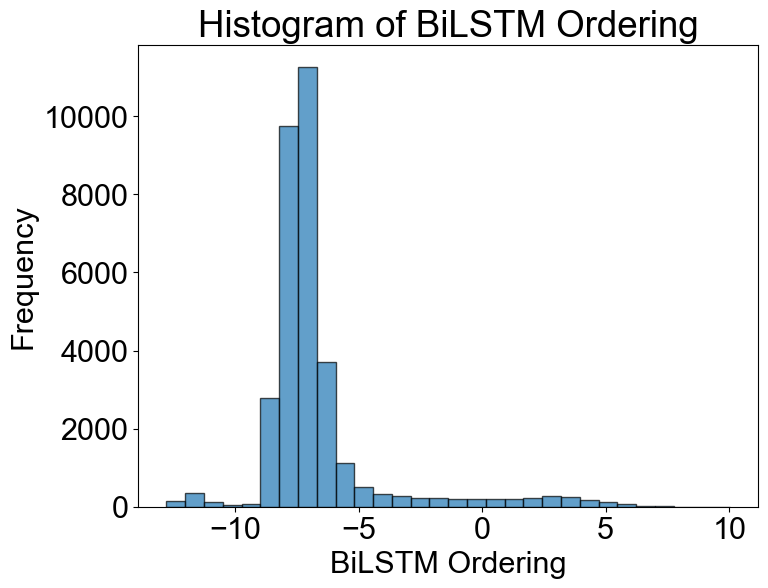

Number of peptides with BiLSTM Ordering > 3.874: 454


In [16]:
# Create histogram
plt.figure(figsize=(8, 6))
plt.hist(df_sorted["BiLSTM Ordering"], bins=30, edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel("BiLSTM Ordering")
plt.ylabel("Frequency")
plt.title("Histogram of BiLSTM Ordering")

# Show plot
plt.show()

count = (df_sorted["BiLSTM Ordering"] > 3.874).sum()
print(f"Number of peptides with BiLSTM Ordering > 3.874: {count}")

226
     A_one_hot_I1  A_one_hot_I2  A_one_hot_I3  A_one_hot_I4  A_one_hot_I5  \
0             1.0           0.0           0.0           0.0           0.0   
1             1.0           0.0           0.0           0.0           0.0   
2             1.0           0.0           0.0           0.0           0.0   
3             1.0           0.0           0.0           0.0           0.0   
4             1.0           0.0           0.0           0.0           0.0   
..            ...           ...           ...           ...           ...   
449           1.0           0.0           0.0           0.0           0.0   
450           0.0           0.0           0.0           0.0           0.0   
451           1.0           0.0           0.0           0.0           0.0   
452           1.0           0.0           0.0           0.0           0.0   
453           1.0           0.0           0.0           0.0           0.0   

     A_one_hot_I6  A_one_hot_I7  A_one_hot_I8  A_one_hot_I9  A_one_hot_

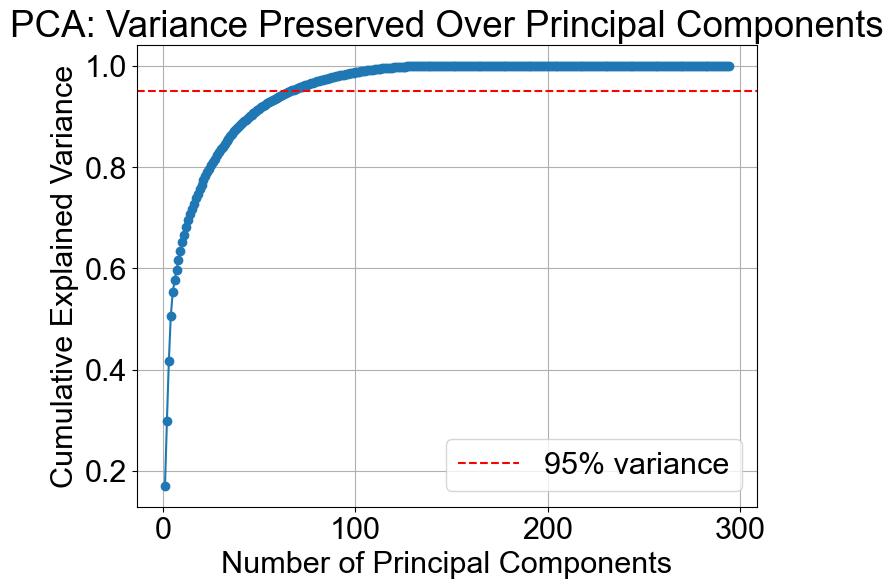

In [23]:
##### PCA clustering
start_col = df_sorted.columns.get_loc("A_one_hot_I1")
print(start_col)
df_numeric = df_sorted.iloc[:454, start_col:].copy()

print(df_numeric)
num_pc = SL_PCA.perform_pca_variance_analysis(df_numeric, L2norm=False)

226
Number of principal components needed to capture 95% variance: 144


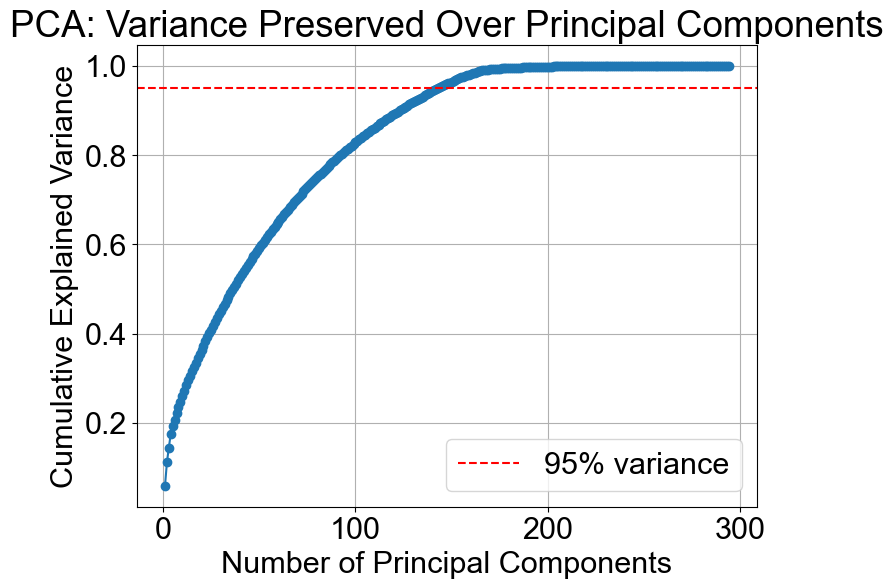

In [18]:
##### PCA clustering
start_col = df_sorted.columns.get_loc("A_one_hot_I1")
print(start_col)
df_numeric = df_sorted.iloc[:, start_col:].copy()

num_pc = SL_PCA.perform_pca_variance_analysis(df_numeric, L2norm=False)

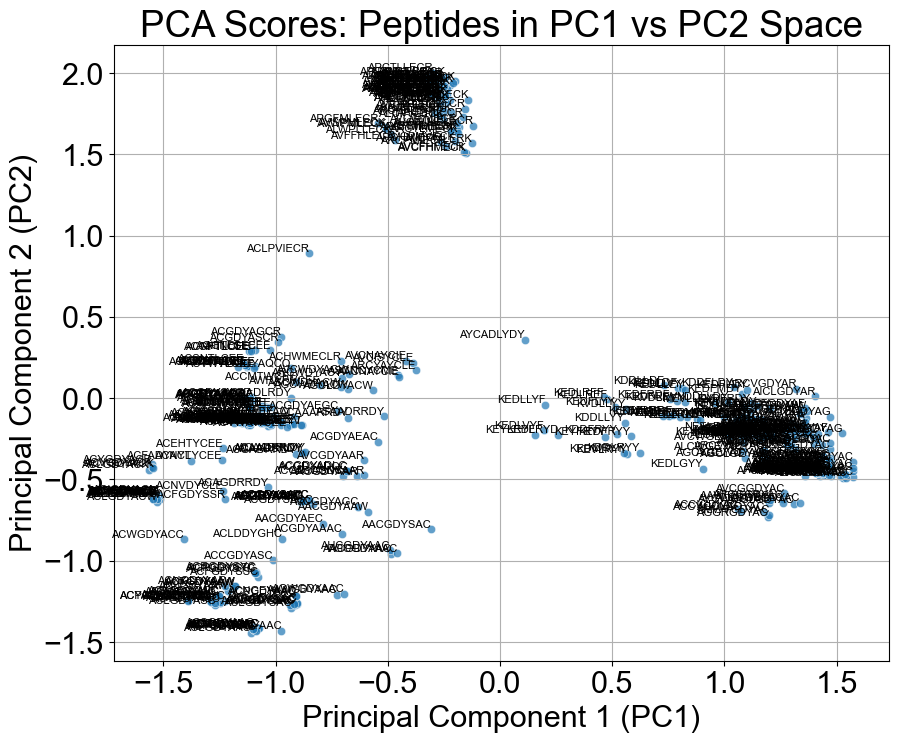

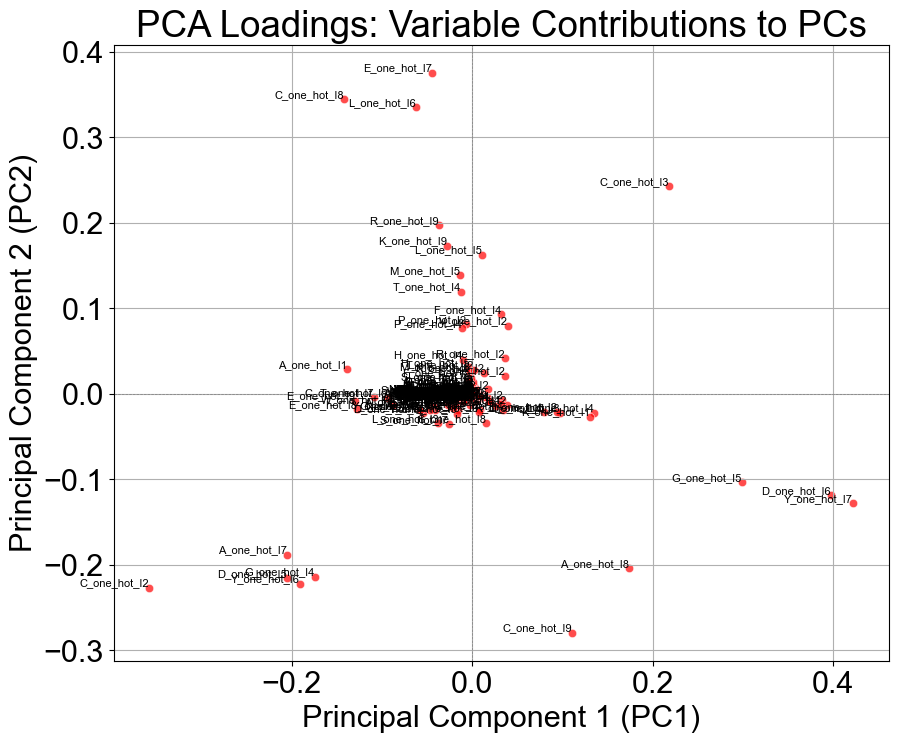

In [22]:
# PCA scores and Loadings for Top 1%
L2norm = False

start_col = df_sorted.columns.get_loc("A_one_hot_I1")
df_numeric_1percent = df_sorted.iloc[:454, start_col:].copy()
df_1_percent_peptides = df_sorted.iloc[0:454, 0].copy()

# Perform PCA
if L2norm: 
    df_numeric_1percent = normalize(df_numeric_1percent, norm="l2")  # L2 normalization

pca = PCA(n_components=2)
pc_values = pca.fit_transform(df_numeric_1percent)
loadings = pca.components_.T  # Loadings matrix (shape: features × PCs)

# Create DataFrame for scores
df_pca = pd.DataFrame(pc_values, columns=["PC1", "PC2"])
df_pca["Peptides"] = df_1_percent_peptides

# Create DataFrame for loadings
df_loadings = pd.DataFrame(loadings, columns=["PC1", "PC2"], index=df_numeric_1percent.columns)

# ---- Plot PCA Scores (Scatterplot) ----
plt.figure(figsize=(10, 8))
sns.scatterplot(x="PC1", y="PC2", data=df_pca, alpha=0.7)

for i, row in df_pca.iterrows():
    plt.text(row["PC1"], row["PC2"], row["Peptides"], fontsize=8, ha="right", va="bottom")

plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.title("PCA Scores: Peptides in PC1 vs PC2 Space")
plt.grid(True)
plt.show()

# ---- Plot PCA Loadings (Biplot Style) ----
plt.figure(figsize=(10, 8))
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)

sns.scatterplot(x="PC1", y="PC2", data=df_loadings, alpha=0.7, color='red')

for i, row in df_loadings.iterrows():
    plt.text(row["PC1"], row["PC2"], row.name, fontsize=8, ha="right", va="bottom")

plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.title("PCA Loadings: Variable Contributions to PCs")
plt.grid(True)
plt.show()

In [24]:
##### PCA clustering

start_col = df_sorted.columns.get_loc("A_one_hot_I1")
df_numeric_1percent = df_sorted.iloc[:454, start_col:].copy()
print(df_numeric_1percent.shape)

if L2norm: 
    df_numeric_1percent = normalize(df_numeric_1percent, norm="l2")  # L2 normalization

# Perform PCA, reducing to 67 principal components
pca = PCA(n_components=67)
pc_values = pca.fit_transform(df_numeric_1percent)

# Create a DataFrame with PC1 and PC2
df_pca = pd.DataFrame(pc_values)

print(df_pca.shape)


(454, 294)
(454, 67)


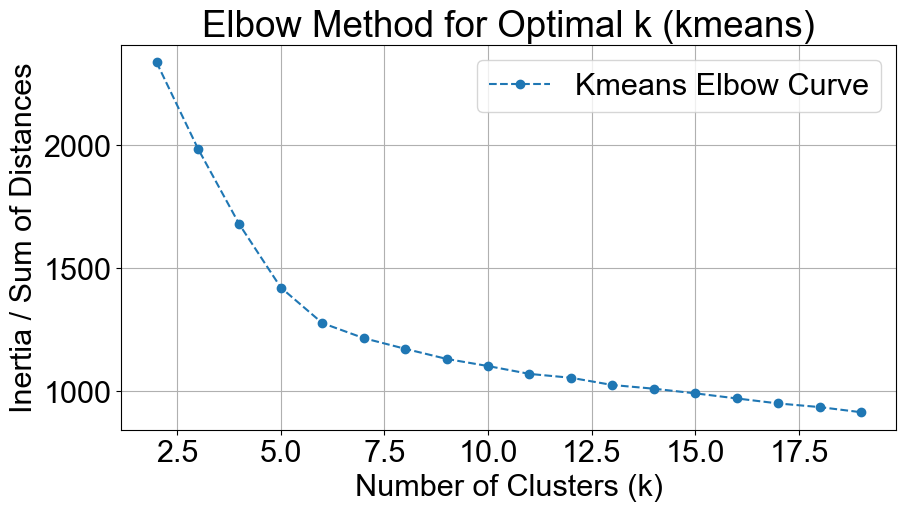

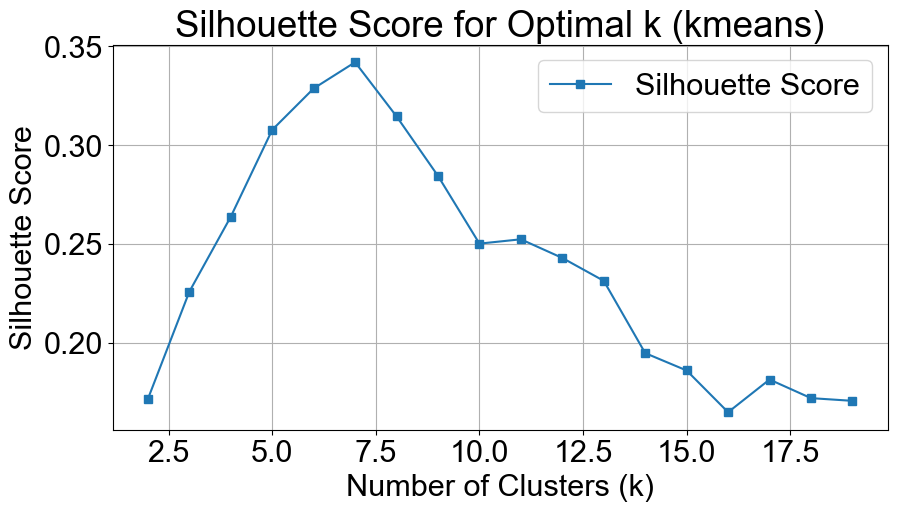

In [25]:
# Evalueate Kmeans clustering on df_pca of top 1%
inertia, sil_scores = SL_PCA.evaluate_clustering(df_pca, cluster_range=range(2, 20), method='kmeans')

(454,)


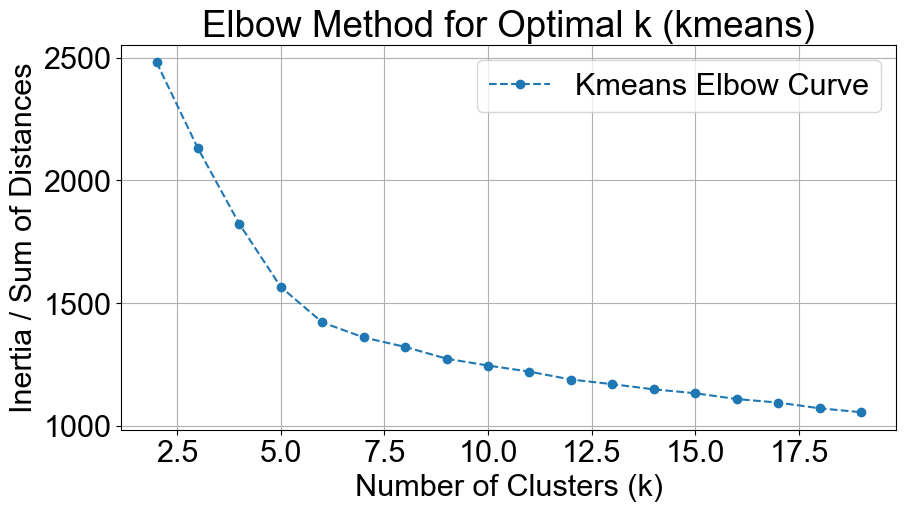

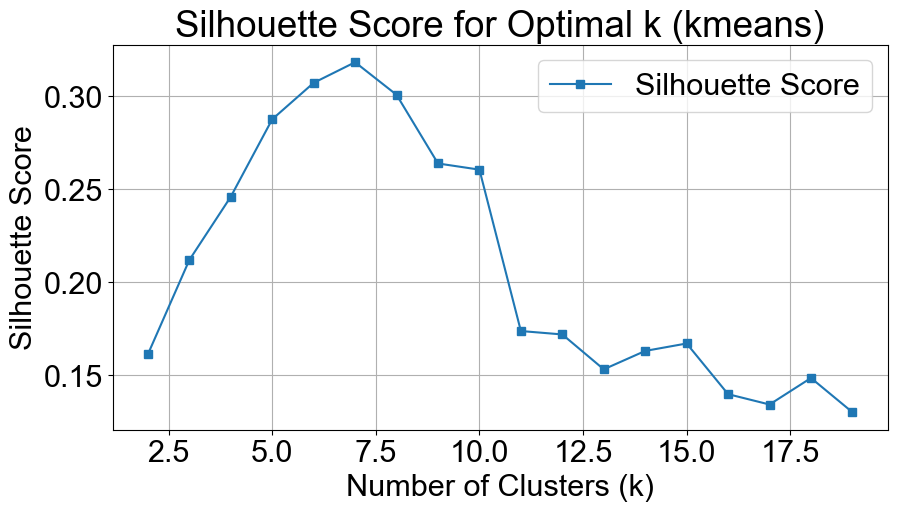

In [26]:
# Does Kmeans clustering on top 1% without PCA

L2norm = False

start_col = df_sorted.columns.get_loc("A_one_hot_I1")
df_features = df_sorted.iloc[:454, start_col:].copy()

# Drop the first two columns (assuming they are non-numeric)
if L2norm: 
    df_features = normalize(df_features, norm="l2")  # L2 normalization
    
df_1_percent_peptides = df_sorted.iloc[:454, 0].copy()
print(df_1_percent_peptides.shape)

inertia, sil_scores = SL_PCA.evaluate_clustering(df_features, cluster_range=range(2, 20), method='kmeans')


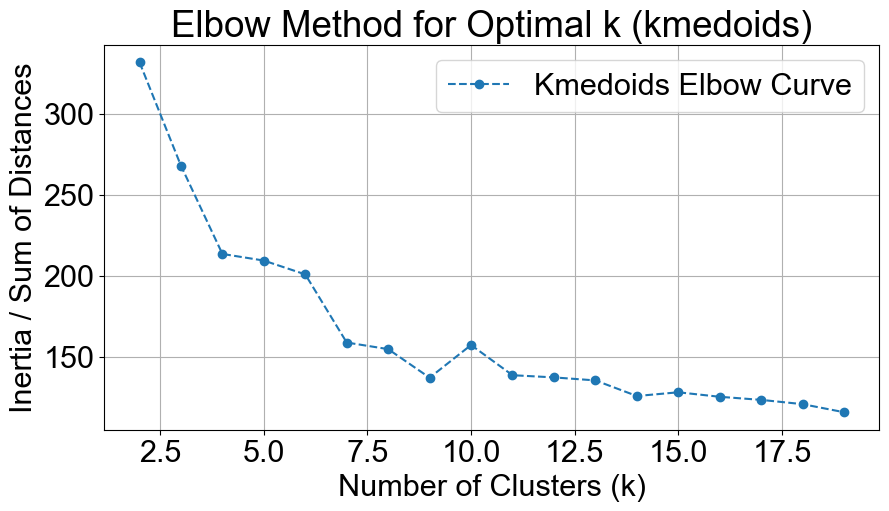

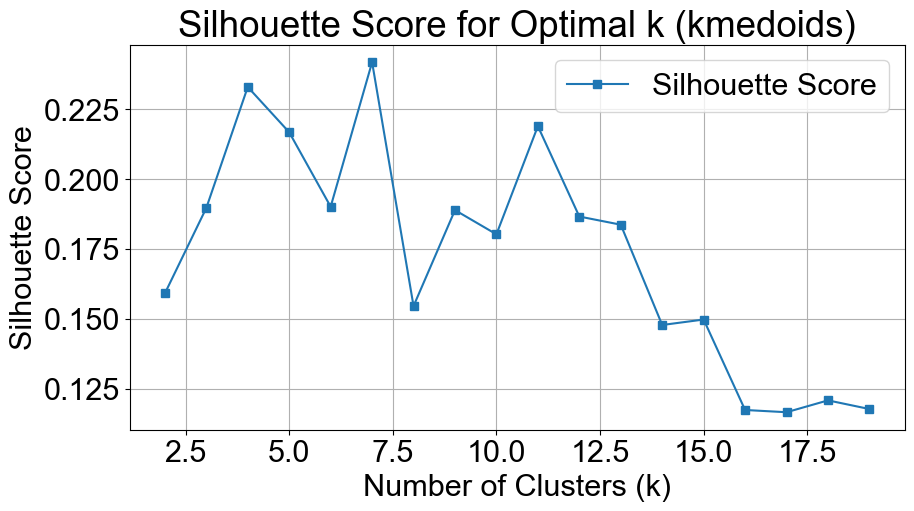

In [27]:
df_pca1 = df_pca.copy()

inertia, sil_scores = SL_PCA.evaluate_clustering(df_pca1, cluster_range=range(2, 20), method='kmedoids')

In [28]:
# Perform K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=7, random_state=42, n_init=100)
cluster_labels = kmeans.fit_predict(df_pca)

# Make a new DataFrame that includes cluster labels
df_pca_with_cluster = df_pca.copy()
df_pca_with_cluster["K-means_Cluster"] = cluster_labels
print(df_pca_with_cluster.head(11))

           0         1         2         3         4         5         6  \
0  -0.223623  1.926209  0.460242 -0.213678 -0.181040  0.505635  0.411649   
1  -1.029285 -0.161216 -0.880904  1.470741 -0.273413 -0.126325 -0.327918   
2  -1.009078 -0.109211 -0.794565  1.286781 -0.188786 -0.129876 -0.039224   
3  -0.254115  1.975519  0.396489 -0.281135 -0.113825  0.639482  0.230504   
4  -0.199606  1.949951  0.407924 -0.271883 -0.200960  0.219719  0.445009   
5  -1.126968  0.193972 -0.829398  1.446484 -0.322339 -0.132182  0.187893   
6  -0.245917  1.875400  0.468636 -0.296131 -0.128794 -0.474194  0.182493   
7   1.212691 -0.232715 -1.671902 -0.783936  0.048990 -0.222501 -0.078803   
8  -1.117340 -0.056363 -1.067918  1.695768 -0.399441  0.593852  0.057692   
9  -1.151361 -0.150344 -1.009614  1.675523 -0.346485 -0.160108 -0.139482   
10 -1.121659  0.198478 -0.836449  1.485561 -0.298309 -0.190598  0.204672   

           7         8         9  ...        58        59        60        61  \
0   0.

In [29]:
##### df_pca kmeans clustering

# Ensure 'Cluster' is included separately for grouping
cluster_means_pca = df_pca_with_cluster.groupby("K-means_Cluster").mean()  # Compute mean one-hot encoding
print(f"Shape of cluster_means: {cluster_means_pca.shape}")
print(cluster_means_pca)

# Inverse transform PCA-reduced cluster means back to approximate one-hot encoding
approx_one_hot_pca = pca.inverse_transform(cluster_means_pca)
print('inverse_pca ',approx_one_hot_pca.shape)
approx_one_hot_pca = np.array(approx_one_hot_pca)

approx_one_hot_df_pca = pd.DataFrame(approx_one_hot_pca, index=cluster_means_pca.index)
print(f"Shape of approximated one-hot encoding: {approx_one_hot_df_pca.shape}")
print(approx_one_hot_df_pca)

# Define amino acids and peptide sequence length
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
num_amino_acids = len(amino_acids)
seq_length = approx_one_hot_df_pca.shape[1] // num_amino_acids  # Determine peptide length
print(f"Determined sequence length: {seq_length}")

def one_hot_to_sequence(mean_one_hot):
    """Convert mean one-hot encoding back to an approximate peptide sequence."""
    sequence = []
    for i in range(seq_length):
        # Extract one-hot encoding for this position
        pos_one_hot = mean_one_hot[i * num_amino_acids : (i + 1) * num_amino_acids]
        
        # Get the most probable amino acid
        most_likely_aa = amino_acids[np.argmax(pos_one_hot)]  
        sequence.append(most_likely_aa)
    
    return "".join(sequence)

# Apply one-hot_to_sequence to each cluster row
average_sequences_pca = {cluster: one_hot_to_sequence(approx_one_hot_df_pca.loc[cluster].values) 
                     for cluster in cluster_means_pca.index}

cluster_mean_AA_pca = average_sequences_pca
print('Cluster_means_pca ',cluster_mean_AA_pca)

# Print the average peptide sequences for each cluster
for cluster, avg_seq in average_sequences_pca.items():
    print(f"Cluster {cluster}: {avg_seq}")

# Count the number of members in each cluster
print(df_pca_with_cluster["K-means_Cluster"].value_counts())

Shape of cluster_means: (7, 67)
                       0         1         2         3         4         5   \
K-means_Cluster                                                               
0               -1.117034 -0.930321  0.616372 -0.714960 -0.351716  0.017272   
1                1.369004 -0.359632  0.740987  0.463599  0.014493  0.006858   
2                0.933163 -0.143633 -1.525767 -0.779311 -0.033087  0.013719   
3               -0.927744 -0.244176  0.049761  0.019453  1.934401  0.018046   
4               -0.271285  1.808950  0.434217 -0.265237 -0.077085 -0.018692   
5               -1.018136 -0.044711 -0.841937  1.399666 -0.319680 -0.037912   
6               -0.731560 -0.196140 -0.114384 -0.054519  0.037548  0.013382   

                       6         7         8         9   ...        57  \
K-means_Cluster                                          ...             
0               -0.017281 -0.061452 -0.010779 -0.031107  ... -0.000508   
1               -0.053385  0.01717

In [30]:
# Perform K-means clustering with 3 clusters

start_col = df_sorted.columns.get_loc("A_one_hot_I1")
df_1_percent_peptides = df_sorted.iloc[:454, 0].copy()

kmeans = KMeans(n_clusters=7, random_state=42, n_init=100)
cluster_labels = kmeans.fit_predict(df_sorted.iloc[:454, start_col:].copy())

# Make a new DataFrame that includes cluster labels
df_with_cluster =  df_sorted.iloc[:454, start_col:].copy()
df_with_cluster["K-means_Cluster"] = cluster_labels
print(df_with_cluster.head())

   A_one_hot_I1  A_one_hot_I2  A_one_hot_I3  A_one_hot_I4  A_one_hot_I5  \
0           1.0           0.0           0.0           0.0           0.0   
1           1.0           0.0           0.0           0.0           0.0   
2           1.0           0.0           0.0           0.0           0.0   
3           1.0           0.0           0.0           0.0           0.0   
4           1.0           0.0           0.0           0.0           0.0   

   A_one_hot_I6  A_one_hot_I7  A_one_hot_I8  A_one_hot_I9  A_one_hot_I10  ...  \
0           0.0           0.0           0.0           0.0            0.0  ...   
1           0.0           0.0           0.0           0.0            0.0  ...   
2           0.0           0.0           0.0           0.0            0.0  ...   
3           0.0           0.0           0.0           0.0            0.0  ...   
4           0.0           0.0           0.0           0.0            0.0  ...   

   X_one_hot_I6  X_one_hot_I7  X_one_hot_I8  X_one_hot_I9  X_o

In [31]:
# Non-PCA

# Ensure 'Cluster' is included separately for grouping
cluster_means = df_with_cluster.groupby("K-means_Cluster").mean()  # Compute mean one-hot encoding
print(f"Shape of cluster_means: {cluster_means.shape}")
print(cluster_means)

approx_one_hot = np.array(cluster_means)


approx_one_hot_df = pd.DataFrame(approx_one_hot, index=cluster_means.index)
print(f"Shape of approximated one-hot encoding: {approx_one_hot_df.shape}")
print(approx_one_hot_df)

# Count the number of members in each cluster
print(df_with_cluster["K-means_Cluster"].value_counts())


approx_one_hot_df_pca = pd.DataFrame(approx_one_hot_pca, index=cluster_means_pca.index)
print(f"Shape of approximated one-hot encoding: {approx_one_hot_df_pca.shape}")
print(approx_one_hot_df_pca)

# Define amino acids and peptide sequence length
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
num_amino_acids = len(amino_acids)
seq_length = approx_one_hot_df_pca.shape[1] // num_amino_acids  # Determine peptide length
print(f"Determined sequence length: {seq_length}")

def one_hot_to_sequence(mean_one_hot):
    """Convert mean one-hot encoding back to an approximate peptide sequence."""
    sequence = []
    for i in range(seq_length):
        # Extract one-hot encoding for this position
        pos_one_hot = mean_one_hot[i * num_amino_acids : (i + 1) * num_amino_acids]
        
        # Get the most probable amino acid
        most_likely_aa = amino_acids[np.argmax(pos_one_hot)]  
        sequence.append(most_likely_aa)
    
    return "".join(sequence)

# Apply one-hot_to_sequence to each cluster row
average_sequences_pca = {cluster: one_hot_to_sequence(approx_one_hot_df_pca.loc[cluster].values) 
                     for cluster in cluster_means_pca.index}

cluster_mean_AA_pca = average_sequences_pca
print('Cluster_means_pca ',cluster_mean_AA_pca)

# Print the average peptide sequences for each cluster
for cluster, avg_seq in average_sequences_pca.items():
    print(f"Cluster {cluster}: {avg_seq}")

# Count the number of members in each cluster
print(df_pca_with_cluster["K-means_Cluster"].value_counts())

Shape of cluster_means: (7, 294)
                 A_one_hot_I1  A_one_hot_I2  A_one_hot_I3  A_one_hot_I4  \
K-means_Cluster                                                           
0                         1.0      0.000000      0.000000      0.000000   
1                         1.0      0.055046      0.000000      0.000000   
2                         1.0      0.068966      0.022989      0.011494   
3                         0.0      0.000000      0.000000      0.000000   
4                         1.0      0.000000      0.000000      0.000000   
5                         1.0      0.015385      0.015385      0.061538   
6                         1.0      0.000000      0.777778      0.888889   

                 A_one_hot_I5  A_one_hot_I6  A_one_hot_I7  A_one_hot_I8  \
K-means_Cluster                                                           
0                    0.000000           0.0      0.000000      0.000000   
1                    0.000000           0.0      0.000000      0.8

In [32]:
#Non-PCA

# Get only one-hot encoding columns (excluding first two cols and 'Cluster')
Top_1_with_cluster = df_with_cluster.copy()
print(f"Shape of Top_1_with_cluster: {Top_1_with_cluster.shape}")

Full_Trimmed_one_hot = df_unordered.iloc[:, 225:].copy()
print(f"Shape of Full_Trimmed_one_hot: {Full_Trimmed_one_hot.shape}")

# Ensure 'Cluster' is included separately for grouping
cluster_means = Top_1_with_cluster.groupby("K-means_Cluster").mean()  # Compute mean one-hot encoding
print(f"Shape of cluster_means: {cluster_means.shape}")
print(cluster_means.head(5))

# Define amino acids and peptide sequence length
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
num_amino_acids = len(amino_acids)
seq_length = cluster_means.shape[1] // num_amino_acids  # Determine peptide length
print(f"Determined sequence length: {seq_length}")

def one_hot_to_sequence(mean_one_hot):
    """Convert mean one-hot encoding back to an approximate peptide sequence."""
    sequence = []
    for i in range(seq_length):
        # Extract one-hot encoding for this position
        pos_one_hot = mean_one_hot.iloc[i * num_amino_acids : (i + 1) * num_amino_acids].values
        
        # Check if the one-hot encoding is correctly structured
        if len(pos_one_hot) != num_amino_acids:
            print(f"Warning: Unexpected length at position {i}: {len(pos_one_hot)}")
            continue
        
        # Get the most probable amino acid
        most_likely_aa = amino_acids[np.argmax(pos_one_hot)]  
        sequence.append(most_likely_aa)
    
    return "".join(sequence)

# Generate average peptide sequence for each cluster
average_sequences = cluster_means.apply(one_hot_to_sequence, axis=1)

# Print the average peptide sequences
for cluster, avg_seq in zip(cluster_means.index, average_sequences):
    print(f"Cluster {cluster}: {avg_seq}")
    
Top_1_with_cluster["K-means_Cluster"].value_counts()

Shape of Top_1_with_cluster: (454, 295)
Shape of Full_Trimmed_one_hot: (32911, 295)
Shape of cluster_means: (7, 294)
                 A_one_hot_I1  A_one_hot_I2  A_one_hot_I3  A_one_hot_I4  \
K-means_Cluster                                                           
0                         1.0      0.000000      0.000000      0.000000   
1                         1.0      0.055046      0.000000      0.000000   
2                         1.0      0.068966      0.022989      0.011494   
3                         0.0      0.000000      0.000000      0.000000   
4                         1.0      0.000000      0.000000      0.000000   

                 A_one_hot_I5  A_one_hot_I6  A_one_hot_I7  A_one_hot_I8  \
K-means_Cluster                                                           
0                         0.0           0.0      0.000000      0.000000   
1                         0.0           0.0      0.000000      0.807339   
2                         0.0           0.0      0.839080

1    109
2     87
0     79
3     75
5     65
4     30
6      9
Name: K-means_Cluster, dtype: int64

In [33]:
# Convert to NumPy arrays
peptide_encodings = np.array(df_unordered.iloc[:, 226:]).copy()  

# Ensure cluster_means is a NumPy array
if isinstance(cluster_means, dict):
    raise TypeError("Error: 'cluster_means' is a dictionary. Convert it to a NumPy array or DataFrame.")
cluster_means_array = np.array(cluster_means)
cluster_means_array_pca = np.array(approx_one_hot_pca) 

# Function to compute Pearson correlation efficiently
def compute_pearson_matrix(peptides, clusters):
    return np.array([[pearsonr(peptide, cluster)[0] for cluster in clusters] for peptide in peptides])

# Function to compute similarity metrics
def compute_similarity_metrics(peptides, clusters):
    return {
        #"Pearson": compute_pearson_matrix(peptides, clusters),
        "Cosine": cosine_similarity(peptides, clusters),
        "Euclidean": -cdist(peptides, clusters, metric='euclidean')  # Negative for similarity convention
    }

# Compute similarities for both normal and PCA cluster means
similarity_results = {metric: compute_similarity_metrics(peptide_encodings, clusters)
                      for metric, clusters in {"K_means Normal": cluster_means_array, "K_means PCA": cluster_means_array_pca}.items()}

# Convert similarity scores to DataFrames
df_similarity = {}
for metric, results in similarity_results.items():
    for sim_type, scores in results.items():
        df_similarity[f"{sim_type}_{metric}"] = pd.DataFrame(scores, 
            columns=[f"Similarity_to_Cluster_{i}" for i in range(scores.shape[1])])

# Create DataFrame for best similarity scores and their corresponding clusters
df_re_ranked = df_unordered.iloc[:,226:].copy()

for key, df in df_similarity.items():
    df_re_ranked[f"Max_{key}"] = df.max(axis=1)  # Highest similarity score
    df_re_ranked[f"Best_{key}_Cluster"] = df.idxmax(axis=1)  # Best-matching cluster

# Print top-ranked peptides
print(df_re_ranked.head())

   A_one_hot_I1  A_one_hot_I2  A_one_hot_I3  A_one_hot_I4  A_one_hot_I5  \
0           0.0           0.0           0.0           0.0           0.0   
1           1.0           0.0           0.0           0.0           0.0   
2           1.0           0.0           0.0           0.0           0.0   
3           1.0           0.0           0.0           0.0           0.0   
4           1.0           0.0           0.0           0.0           0.0   

   A_one_hot_I6  A_one_hot_I7  A_one_hot_I8  A_one_hot_I9  A_one_hot_I10  ...  \
0           0.0           1.0           0.0           0.0            0.0  ...   
1           0.0           0.0           0.0           0.0            0.0  ...   
2           0.0           0.0           0.0           0.0            0.0  ...   
3           0.0           0.0           0.0           0.0            0.0  ...   
4           0.0           0.0           0.0           0.0            0.0  ...   

   X_one_hot_I13  X_one_hot_I14  Max_Cosine_K_means Normal  \


In [34]:
# Create copies of the original DataFrames
df_resorted = df_re_ranked.copy()

# Extract all similarity score columns dynamically
similarity_columns = [col for col in df_resorted.columns if "Max" in col]

# Dictionary to store K-means ordering values
KmeansSL_orderings = {col: df_resorted[col].values for col in similarity_columns}

# Print keys to verify
print("K-means Orderings:", KmeansSL_orderings.keys())

K-means Orderings: dict_keys(['Max_Cosine_K_means Normal', 'Max_Euclidean_K_means Normal', 'Max_Cosine_K_means PCA', 'Max_Euclidean_K_means PCA'])


In [35]:
from matplotlib.pyplot import figure

# Set figure size and DPI
figure(figsize=(12, 12), dpi=80)

# Define static rankings, but start with XSTREME
rankings = [
    (fimo_rank, "XSTREME_Ranking", "#5757F9"),
]

# Add ONLY 'Max_Cosine_K_means PCA' from the K-means results
if 'Max_Cosine_K_means PCA' in KmeansSL_orderings:
    rankings.append((
        KmeansSL_orderings['Max_Cosine_K_means PCA'],
        'Max_Cosine_K_means PCA',
        "#E69F00"  # Or any custom color you like
    ))

# Add the rest of the static rankings
rankings.extend([
    (bilstm_ordering, "BiLSTM Model Ranking", "#F94040"),
    (er_mdm2_ordering, 'ER Ranking', '#D55E00'),
    (er_fc_joint_mdm2_ordering, "Joint ER/FC Ranking", "#0F980F"),
    (volcano_ordering, "Joint FC/Pval Ranking", "#5757F9"),
    (fc_alone_mdm2_ordering, 'FC Ranking', '#56B4E9')
])

# Confirm final order and content
print("Included Ranking Keys in Legend:")
for _, label, _ in rankings:
    print(label)

Included Ranking Keys in Legend:
XSTREME_Ranking
Max_Cosine_K_means PCA
BiLSTM Model Ranking
ER Ranking
Joint ER/FC Ranking
Joint FC/Pval Ranking
FC Ranking


<Figure size 960x960 with 0 Axes>

0.6080990099009901
0.6117029702970297
0.49665346534653465
0.1392871287128713
0.23445544554455444
0.37055445544554455
0.37813861386138614


0.6117029702970297

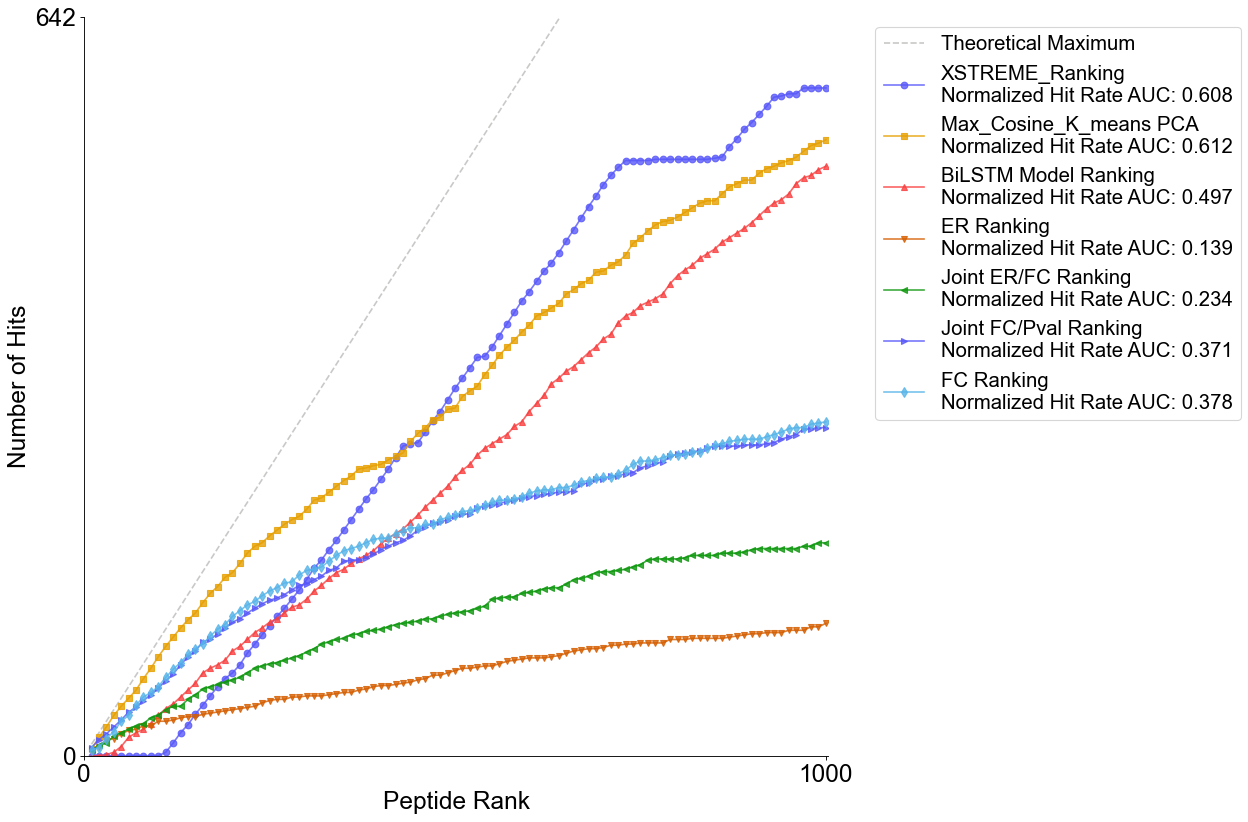

In [36]:
protein_of_interest = "12ca5"
from matplotlib.pyplot import figure
figure(figsize=(12, 12), dpi=80)

plot_ratio_by_ranking(
    peptides=peptides,
    y_rankings=rankings,
    title="",
    peptide_dataset_size=top_k_size,
    hit_rate_func=seq_contains_mdm2_motif if protein_of_interest =="MDM2" else seq_contains_12ca5_motif,
    save_file='mdm2_hit_rankings.csv' if protein_of_interest =='MDM2' else '12ca5_hit_rankings.csv',
)